# **Sentiment Analysis of Amazon Product Reviews**

 _Mitansh Maheshwari_  
_Date - 12/2/2024_

---

### Overview
This project involves performing sentiment analysis on Amazon product reviews from the **CDs & Vinyl** category, using data up to 2023. The goal is to understand customer sentiments towards products in this category, providing insights into the relationship between product ratings, review sentiments, and other features like price, category, and word count.

By analyzing the sentiment of customer reviews, this project seeks to identify patterns in customer satisfaction and how different product features influence customer sentiment.

### Problem Statement

Given the variety of products and customer feedback, understanding customer sentiment is crucial for both product development and customer satisfaction. The challenge lies in analyzing large volumes of text data from reviews and drawing meaningful conclusions about customer feelings, preferences, and the impact of product features on sentiment.

### Dataset Structure and Source

The dataset used for this project is provided by **McAuley Lab, UCSD**. You can access the dataset and more details on their official site: [McAuley Lab, UCSD](https://amazon-reviews-2023.github.io/).

#### Dataset Structure:
The dataset includes product information and reviews, structured as follows:

- **Product Data**:
  - **main_category**: The primary product category (e.g., "Digital Music").
  - **title**: The product title (e.g., "Release Some Tension").
  - **average_rating**: The average product rating.
  - **rating_number**: The number of ratings for the product.
  - **price**: The price of the product.
  - **store**: The product's store details (e.g., format and seller).
  - **categories**: Categories the product belongs to.
  - **parent_asin**: The Amazon Standard Identification Number (ASIN) for the product.
  - **reviews**: A list of reviews for the product.

- **Review Data**:
  - **rating**: The individual review rating.
  - **title**: The title of the review.
  - **text**: The content of the review.
  - **timestamp**: The timestamp of the review.
  - **verified_purchase**: Indicates if the purchase was verified.
  - **sentiment_score**: The sentiment score of the review.
  - **word_count**: The number of words in the review text.

Example structure of data **Before Cleaning**:
```json
{
  "main_category": "Digital Music",
  "title": "The Musicality of Kander & Ebb",
  "average_rating": 4.5,
  "rating_number": 5,
  "features": [],
  "description": [],
  "price": 12.99,
  "images": [
    {
      "thumb": "https://m.media-amazon.com/images/I/41WVG9KA55L._SS40_.jpg",
      "large": "https://m.media-amazon.com/images/I/41WVG9KA55L.jpg",
      "variant": "MAIN",
      "hi_res": null
    }
  ],
  "videos": [],
  "store": "John Kander (Performer), Fred Ebb (Performer), Matt Bogart (Performer), Susan Egan (Performer) & 1 more  Format: Audio CD",
  "categories": [
    "CDs & Vinyl",
    "Broadway & Vocalists",
    "Musicals"
  ],
  "details": {
    "Is Discontinued By Manufacturer": "No",
    "Product Dimensions": "5.86 x 0.4 x 5.64 inches; 3.52 Ounces",
    "Manufacturer": "Jay Records",
    "Date First Available": "February 12, 2007",
    "Label": "Jay Records",
    "Number of discs": "1"
  },
  "parent_asin": "B0000C23CO",
  "bought_together": null,
  "reviews": [
    {
      "rating": 5.0,
      "title": "a fun listening experience...",
      "text": "I know little about Broadway, but I loved this CD. It was a fun listen (and made me want to find similar music). I have heard the song New York, New York many times, but I have never heard it sung with such power and conviction as Sean McDermott does on this CD. Boom, Diddy, Boom was unbelievable...in a funny-nice way, as was The Apple Doesn't Fall Very Far From the Tree. All of the songs were well done. The change in volume took a little getting used to (especially in the car).",
      "images": [],
      "asin": "B0000C23CO",
      "parent_asin": "B0000C23CO",
      "user_id": "AEIOC33ZZ6ZUFRAOBRTOGO6ZLRZA",
      "timestamp": 1376056722000,
      "helpful_vote": 4,
      "verified_purchase": true
    }
  ]
}
```

### Objective

The primary objective of this project is to analyze sentiment in customer reviews of products in the **CDs & Vinyl** category. Specifically, the goals include:

- Understanding how sentiment correlates with product ratings.
- Analyzing how product features such as price, category, and word count influence sentiment.
- Investigating the distribution of sentiment scores (positive, negative, neutral) across different products.

By performing this analysis, the project aims to generate actionable insights that can assist in product development, marketing, and customer feedback evaluation.

### Methodology

#### 1. Data Cleaning (Wrangling)
The first step involves cleaning the dataset by:
- Handling missing values and irrelevant data.
- Standardizing the structure of both product and review information.
- Converting timestamps into a readable format.
- Removing or filling incomplete fields.

#### 2. Feature Engineering
Feature engineering is crucial to extract meaningful information:
- Text is Pre-Processed. Operations like Removing stopwords, Tokenization etc. are performed.
- Sentiment scores are calculated for each review using sentiment analysis tools.
- Product-level features such as average sentiment score, review count, and price range are derived.
- Aggregated review information, such as the count of positive, negative, and neutral reviews, is calculated.

#### 3. Exploratory Data Analysis (EDA)
EDA focuses on gaining insights from the dataset:
- Distribution of ratings and sentiment scores across reviews.
- Relationships between sentiment scores and ratings.
- Product-level comparison in terms of review sentiment and product features.

#### 4. Data Visualization
Data visualization is used to communicate key insights:
- Distribution plots for ratings and sentiment scores.
- Heatmaps or scatter plots to identify correlations between review sentiment and product features.

### Purpose

The purpose of this project is to create a system capable of:
- Identifying trends and patterns in customer sentiment.
- Understanding how customer sentiments vary across different product categories and features.
- Leveraging this sentiment analysis to improve marketing strategies and product offerings.

### Conclusion

By applying sentiment analysis to Amazon product reviews, this project provides valuable insights into customer perceptions of products in the **CDs & Vinyl** category. The insights gained from this analysis can help businesses understand customer satisfaction, identify areas for improvement, and enhance product offerings. Additionally, it demonstrates the power of text analytics and machine learning in extracting insights from large, unstructured datasets such as customer reviews.

------------------------------------

## Part 1. Data Cleaning/Wrangling
In this section, we focus on the crucial task of data cleaning and wrangling to prepare the dataset for analysis. This process ensures the data's quality and consistency, allowing for accurate insights to be drawn from it. The data cleaning and wrangling were carried out in three key steps: 


### Step 1: Removing Unnecessary Fields

#### Description
This Python script reads a large JSON Lines (JSONL) file line by line, processes each entry to remove the specified fields, and writes the cleaned data into a new JSONL file. The script is optimized for handling large datasets by processing entries incrementally to avoid memory overload, making it suitable for datasets containing millions of records.

- **Field Removal**: Removes non-essential fields (such as `images`, `videos`, `details`, `features`, `bought_together`, and `description`) from each entry to focus on the most relevant data.
- **Memory Efficiency**: Processes each line independently, without loading the entire file into memory, making it efficient even for large datasets.
- **Scalability**: Capable of handling datasets with millions of entries due to its line-by-line processing approach.
- **Preserves Original Structure**: Maintains the integrity of the remaining data fields, ensuring that the cleaned dataset is ready for subsequent analysis.

In [1]:
import json

# Input and output file paths
input_file = "updated_metadata.jsonl"
output_file = "cleaned_metadata.jsonl"

# Fields to remove
fields_to_remove = ["images", "videos", "details", "features", "bought_together", "description"]

# Process the file
with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        entry = json.loads(line.strip())  # Load the JSON object
        # Remove the specified fields
        for field in fields_to_remove:
            entry.pop(field, None)
        # Write the cleaned entry to the output file
        outfile.write(json.dumps(entry) + "\n")

print(f"Cleaned data written to {output_file}")


Cleaned data written to cleaned_metadata.jsonl


### Step 2: Cleaning Reviews

#### Description:
The purpose of this step is to preprocess the `cleaned_metadata.jsonl` file by removing unnecessary subfields from the `reviews` field. This process ensures that only the relevant information for sentiment analysis is retained in the reviews data, making it cleaner and more focused for downstream processing. In this step, we focus on cleaning the `reviews` field within each entry of the `cleaned_metadata.jsonl` file. Specifically, we remove the following unwanted subfields from each review:

- `parent_asin`
- `user_id`
- `asin`
- `helpful_vote`
- `images`

These fields are irrelevant for sentiment analysis, as they do not contribute to evaluating the tone or opinion expressed in the review. By removing these fields, we reduce noise in the dataset, streamline the structure, and make it easier to analyze the sentiment of the reviews based on the remaining relevant fields, such as `rating`, `title`, `text`, and `timestamp`.

In [2]:
import json

# Input and output file paths (same file for input and output)
file_path = "cleaned_metadata.jsonl"

# Fields to remove within the reviews
review_fields_to_remove = ["parent_asin", "user_id", "asin", "helpful_vote", "images"]

# Process the file
with open(file_path, "r", encoding="utf-8") as infile:
    lines = infile.readlines()  # Read all lines into memory

# Modify the data
modified_lines = []
for line in lines:
    entry = json.loads(line.strip())  # Load the JSON object
    
    # Clean the reviews field
    if "reviews" in entry and isinstance(entry["reviews"], list):
        cleaned_reviews = []
        for review in entry["reviews"]:
            # Remove specified fields in each review
            cleaned_review = {k: v for k, v in review.items() if k not in review_fields_to_remove}
            cleaned_reviews.append(cleaned_review)
        entry["reviews"] = cleaned_reviews

    # Prepare the modified entry for output
    modified_lines.append(json.dumps(entry))

# Overwrite the file with the modified data
with open(file_path, "w", encoding="utf-8") as outfile:
    for modified_line in modified_lines:
        outfile.write(modified_line + "\n")

print(f"Reviews cleaned and file {file_path} updated.")

Reviews cleaned and file cleaned_metadata.jsonl updated.


### Step 3: Filtering Reviews by Verified Purchase

#### Description:
The purpose of this step is to filter the reviews in the `cleaned_metadata.jsonl` file based on the `verified_purchase` field. This ensures that only reviews from verified purchases are retained, which can improve the quality of sentiment analysis by eliminating potential bias from unverified or non-purchase reviews. In this step, we process each entry in the `cleaned_metadata.jsonl` file and filter the reviews based on the `verified_purchase` field. Only reviews where `verified_purchase` is `True` are kept. This allows us to focus on reviews that are more likely to come from genuine customers who have actually purchased the product, leading to more reliable sentiment analysis results.


In [3]:
import json

# Define the file path
file_path = 'cleaned_metadata.jsonl'

# Read the file, filter the reviews, and write back to the same file
with open(file_path, 'r+') as file:
    lines = file.readlines()  # Read all lines into a list
    file.seek(0)  # Move the file pointer to the beginning
    file.truncate()  # Clear the file content

    # Process each line and filter the reviews
    for line in lines:
        data = json.loads(line)  # Parse the JSON data
        
        # Check if 'reviews' exists, then filter the reviews based on 'verified_purchase'
        if 'reviews' in data:
            # Only keep reviews where 'verified_purchase' is True
            data['reviews'] = [review for review in data['reviews'] if review.get('verified_purchase', False) is True]

        # Write the cleaned data back to the same file
        json.dump(data, file)
        file.write('\n')

print(f"File {file_path} has been updated with filtered reviews.")


File cleaned_metadata.jsonl has been updated with filtered reviews.


### Step 4: Converting Timestamps and Removing HTML Tags

#### Description:
The purpose of this step is to preprocess the `cleaned_metadata.jsonl` file by converting Unix timestamps into human-readable dates and removing HTML tags from the review text. This helps make the dataset more accessible and easier to analyze, particularly for time-based analysis and text mining tasks such as sentiment analysis. In this step, we apply two transformations to each review in the `cleaned_metadata.jsonl` file:

1. **Timestamp Conversion:** The Unix timestamp in each review's `timestamp` field is converted to a readable date and time format (`YYYY-MM-DD HH:MM:SS`).
2. **HTML Tag Removal:** Any HTML tags in the review's `text` field are stripped out to ensure that the text is clean for further text analysis or sentiment evaluation.

In [4]:
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup

# Load your cleaned data
import json

# Read the cleaned metadata (ensure it's in the proper JSON format for manipulation)
with open("cleaned_metadata.jsonl", "r") as file:
    cleaned_data = [json.loads(line) for line in file]

# Function to convert Unix timestamp to a readable date
def convert_timestamp(timestamp):
    # Convert milliseconds to seconds for datetime conversion
    return datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')

# Function to remove HTML tags from the review text
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Apply the transformations to the data
for entry in cleaned_data:
    # Convert timestamp for each review
    for review in entry.get('reviews', []):
        review['timestamp'] = convert_timestamp(review['timestamp'])
        # Remove HTML tags in the review text
        review['text'] = remove_html_tags(review['text'])

# Save the updated data back to cleaned_metadata.jsonl
with open("cleaned_metadata.jsonl", "w") as file:
    for entry in cleaned_data:
        file.write(json.dumps(entry) + "\n")

print("Timestamp converted and HTML tags removed successfully.")

C:\Users\mitan\AppData\Local\Temp\ipykernel_29320\3263700859.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')
C:\Users\mitan\AppData\Local\Temp\ipykernel_29320\3263700859.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
C:\Users\mitan\AppData\Local\Temp\ipykernel_29320\3263700859.py:19: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


Timestamp converted and HTML tags removed successfully.


## Part 2. Feature Engineering
In this step, we will enhance our dataset by creating new features that can provide deeper insights into listening habits and preferences. Feature engineering is a critical process in data analysis and machine learning, as it can significantly improve the performance of models by introducing informative attributes. Below are the newly created variables/features:

### 1. Review Count and Price Categorization

#### Description:
The purpose of this step is to enhance the dataset by adding two new features: `review_count` and `price_range`. These features will provide additional context for each product, such as the number of reviews and the price category, which could be valuable for downstream analysis, including sentiment analysis and product comparison. In this step, we add the following features to the dataset:

1. **Review Count (`review_count`):** A new field is added that counts the number of reviews associated with each product. This helps to quantify how much feedback a product has received.
   
2. **Price Range (`price_range`):** A price category is determined based on the product's price:
   - **Low:** If the price is less than $15.
   - **Medium:** If the price is between $15 and $35.
   - **High:** If the price is greater than $35.
   
   If the price is missing or cannot be converted to a number, the `price_range` is set to 'unknown'.

In [5]:
import json

# Function to add Review Count feature
def add_review_count(data):
    for entry in data:
        entry['review_count'] = len(entry.get('reviews', []))  # Count reviews for each product
    return data

# Function to add Price Range feature, handling null prices and converting to numeric
def add_price_range(data):
    for entry in data:
        price = entry.get('price', None)  # Get the price, default to None if not present
        
        # If the price is None or empty, set to 'unknown'
        if price is None or price == '':
            entry['price_range'] = 'unknown'  # Set as 'unknown' if price is missing or empty
        else:
            try:
                # Convert price to float to ensure proper comparison
                price = float(price)
                if price < 15:
                    entry['price_range'] = 'low'
                elif 15 <= price < 35:
                    entry['price_range'] = 'medium'
                else:
                    entry['price_range'] = 'high'
            except ValueError:
                # If conversion fails (e.g., if price is non-numeric), set it as 'unknown'
                entry['price_range'] = 'unknown'
    
    return data

# Load the cleaned data from the cleaned_metadata.jsonl file
with open("cleaned_metadata.jsonl", "r") as file:
    cleaned_data = [json.loads(line) for line in file]

# Apply Review Count and Price Range feature engineering
cleaned_data = add_review_count(cleaned_data)
cleaned_data = add_price_range(cleaned_data)

# Save the updated data with the new features to the same file
with open("cleaned_metadata.jsonl", "w") as file:
    for entry in cleaned_data:
        file.write(json.dumps(entry) + "\n")

print("Review Count and Price Range features added successfully, handling null and non-numeric prices.")

Review Count and Price Range features added successfully, handling null and non-numeric prices.


### 2. Assigning Sentiment Scores and Text Preprocessing

#### Objective:
This section preprocesses the review text, computes sentiment scores using VADER, and adjusts these scores based on the product rating to generate a combined sentiment score for each review.

#### Description:
This step involves multiple Natural Language Processing (NLP) techniques:
- **Text Preprocessing**: It includes cleaning the text by removing special characters, tokenizing words, and applying stopword removal, stemming, and lemmatization to improve the text for analysis.
- **Sentiment Analysis**: The VADER sentiment analysis tool is used to compute a sentiment score based on the review text. The score is adjusted according to the review rating to provide a more comprehensive sentiment value, blending both textual sentiment and the numerical rating provided by the reviewer.

#### Features:
- **Text Preprocessing**: Removes noise from the review text, ensuring that only relevant information is used in sentiment analysis.
- **VADER Sentiment Analysis**: Generates sentiment scores ranging from -1 (negative) to 1 (positive) based on the content of the review.
- **Rating Adjustment**: Adjusts sentiment scores based on the review rating (from 1 to 5), normalizing the score to a scale from -1 to 1 and averaging it with the text sentiment for a combined score.

#### Methodology:
1. **Text Processing**:
   - The review text is converted to lowercase, special characters are removed, and tokenization is applied.
   - Stopwords are filtered out, and stemming or lemmatization is performed to standardize words for better analysis.
   
2. **Sentiment Scoring**:
   - Each review is analyzed using VADER sentiment analysis to obtain a "compound" score.
   
3. **Rating Adjustment**:
   - The review's rating is normalized to the range [1, 5], where 1 is considered a positive sentiment and 5 is considered negative.
   - A combined sentiment score is generated by averaging the text sentiment with the normalized rating sentiment.

#### Conclusion:
This step generates a sentiment score for each review, considering both the textual content and the review rating. These sentiment scores are then added to the dataset, enriching it for further analysis.

In [6]:
import json
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download NLTK resources (run once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

# Function to preprocess text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters (keep alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and apply stemming or lemmatization
    tokens = [lemmatizer.lemmatize(ps.stem(word)) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to get sentiment score (VADER)
def get_sentiment_score(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Compound score ranges from -1 (negative) to 1 (positive)

# Function to adjust sentiment score based on rating
def adjust_sentiment_based_on_rating(rating, text_sentiment):
    # Normalize rating to scale -1 to 1 (1 is negative, 5 is positive)
    rating_sentiment = 2 * (rating / 5) - 1
    
    # Combine text sentiment and rating sentiment (average them)
    # Adjust the weights depending on how much importance you want to give to the rating vs text
    combined_sentiment = (text_sentiment + rating_sentiment) / 2
    return combined_sentiment

# File path
file_path = 'cleaned_metadata.jsonl'

# Read the file, preprocess the text, and add sentiment scores
with open(file_path, 'r+') as file:
    lines = file.readlines()  # Read all lines into a list
    file.seek(0)  # Move the file pointer to the beginning
    file.truncate()  # Clear the file content

    # Process each line
    for line in lines:
        data = json.loads(line)  # Parse the JSON data

        # Check if 'reviews' exists and process each review
        if 'reviews' in data:
            for review in data['reviews']:
                # Preprocess the review text
                cleaned_text = preprocess_text(review.get('text', ''))
                # Get sentiment score for the review text
                text_sentiment = get_sentiment_score(cleaned_text)
                # Adjust sentiment score based on the rating
                final_sentiment = adjust_sentiment_based_on_rating(review.get('rating', 0), text_sentiment)
                # Add the final sentiment score to the review
                review['sentiment_score'] = final_sentiment

        # Write the updated data back to the same file
        json.dump(data, file)
        file.write('\n')

print(f"File {file_path} has been updated with sentiment scores.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


File cleaned_metadata.jsonl has been updated with sentiment scores.


### 3. Word Count and Average Sentiment Score

#### Description:
The goal of this section is to enrich the dataset by adding two key features: **word count** for each review and **average sentiment score** for the product. These features will help in understanding the depth of the reviews and the overall sentiment associated with the product.

This section processes the `cleaned_metadata.jsonl` file by adding two important features for each product:
1. **Word Count**: This counts the number of words in each review to capture the review's length and provide a measure of review verbosity.
2. **Average Sentiment Score**: This calculates the average sentiment score of all reviews for each product. The sentiment score was already computed in the previous step, and this metric aggregates those individual scores to represent the overall sentiment for the product.

This step enhances the dataset with two additional features: word count and average sentiment score, both of which provide useful insights into the content and sentiment of the reviews for each product. These features can be used for further analysis, including exploring trends in review length and product sentiment.

In [7]:
import json

# Open the JSONL file
file_path = "cleaned_metadata.jsonl"

# Process data line by line
with open(file_path, "r+") as file:
    lines = file.readlines()
    file.seek(0)  # Reset pointer to the start of the file

    for line in lines:
        data = json.loads(line)  # Parse JSON data
        
        # Add word_count for each review
        if "reviews" in data:
            for review in data["reviews"]:
                review["word_count"] = len(review["text"].split())
        
            # Compute average_sentiment_score
            total_sentiment = sum(review["sentiment_score"] for review in data["reviews"])
            data["average_sentiment_score"] = total_sentiment / len(data["reviews"]) if data["reviews"] else 0.0
        else:
            data["average_sentiment_score"] = 0.0  # Default if no reviews
        
        # Write updated JSON data back to file
        file.write(json.dumps(data) + "\n")
    
    file.truncate()  # Remove any leftover data from previous content

### 4. Review Sentiment Categorization

#### Description:
This section categorizes reviews based on their sentiment scores into **positive**, **negative**, or **neutral** reviews. It also computes the count of each sentiment category for each product, enriching the dataset with insights into the distribution of sentiments across reviews.

In this step, the sentiment of each review is assessed using its sentiment score:
- **Positive**: If the sentiment score is greater than 0.2, the review is considered positive.
- **Negative**: If the sentiment score is less than -0.1, the review is considered negative.
- **Neutral**: If the sentiment score lies between -0.1 and 0.2, the review is categorized as neutral.

The counts of positive, negative, and neutral reviews are added to each product's data, which can be valuable for understanding the overall sentiment distribution.

- **Positive Reviews Count**: The number of reviews with a positive sentiment score.
- **Negative Reviews Count**: The number of reviews with a negative sentiment score.
- **Neutral Reviews Count**: The number of reviews with a neutral sentiment score.

This step adds three new features to the dataset: the counts of positive, negative, and neutral reviews. These features provide a deeper understanding of the sentiment distribution within a product’s reviews, which can be useful for product sentiment analysis, trend identification, or marketing insights.

In [8]:
import json

# Path to your JSONL file
file_path = "cleaned_metadata.jsonl"

# Temporary list to hold processed data
processed_data = []

# Read the JSONL file line by line
with open(file_path, "r") as infile:
    for line in infile:
        # Parse each line as a JSON object
        data = json.loads(line)
        
        # Initialize counts
        positive_reviews_count = 0
        negative_reviews_count = 0
        neutral_reviews_count = 0
        
        # Process reviews and count sentiment categories
        if "reviews" in data:
            for review in data["reviews"]:
                score = review.get("sentiment_score", 0)
                if score > 0.2:
                    positive_reviews_count += 1
                elif score < -0.1:
                    negative_reviews_count += 1
                else:
                    neutral_reviews_count += 1
        
        # Add counts to the data
        data["positive_reviews_count"] = positive_reviews_count
        data["negative_reviews_count"] = negative_reviews_count
        data["neutral_reviews_count"] = neutral_reviews_count
        
        # Append updated data to the processed list
        processed_data.append(data)

# Optional: Write the updated dataset back to the same file (or print/save as needed)
with open(file_path, "w") as outfile:
    for record in processed_data:
        outfile.write(json.dumps(record) + "\n")

### Updated Structure of the Data After Cleaning and Feature Engineering

The updated data, following cleaning and feature engineering, is stored in the `cleaned_metadata.jsonl` file. Below is an example of the updated structure for a product:

```json
{
  "main_category": "Digital Music",
  "title": "Release Some Tension",
  "average_rating": 4.6,
  "rating_number": 112,
  "price": 12.05,
  "store": "SWV Format: Audio CD",
  "categories": ["CDs & Vinyl", "Dance & Electronic", "House"],
  "parent_asin": "B000002X4C",
  "reviews": [
    {
      "rating": 1.0,
      "title": "Too Many Guest Spots",
      "text": "Unlike It's About Time and New Beginning, this album is bogged down with so many guest stars...",
      "timestamp": "2013-09-16 20:19:59",
      "verified_purchase": true,
      "sentiment_score": -0.5787,
      "word_count": 83
    },
    {
      "rating": 5.0,
      "title": "Thanks",
      "text": "Thank you",
      "timestamp": "2015-03-27 18:15:21",
      "verified_purchase": true,
      "sentiment_score": 0.6806,
      "word_count": 2
    }
  ],
  "review_count": 2,
  "price_range": "low",
  "average_sentiment_score": 0.35231,
  "positive_reviews_count": 1,
  "negative_reviews_count": 1,
  "neutral_reviews_count": 0
}
```

## Part 3. Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an approach to analyzing datasets to summarize their main characteristics, often with visual methods. It involves inspecting data distributions, identifying patterns, detecting outliers, and understanding relationships between variables. EDA is an essential step in data analysis as it helps uncover insights, guide further analysis, and ensure that data is clean and suitable for modeling or decision-making. By visualizing and summarizing data, EDA helps to reveal trends, correlations, and anomalies that may not be immediately apparent through raw data alone.


### 1. General Sentiment Analysis

This section focuses on analyzing the sentiment expressed in product reviews from the dataset. The goal is to evaluate the overall sentiment of user reviews, determine the distribution of sentiment scores, and gain insights into how customers feel about the products. Specifically, the following aspects are covered:

#### Key Objectives:
- **Distribution of Sentiment Scores**: This involves calculating the mean, median, and standard deviation of sentiment scores to understand the overall sentiment expressed in the reviews. These metrics provide a sense of whether reviews are generally positive, negative, or neutral, and how much variability exists in the sentiment.
  
  - **Mean Sentiment Score**: This is the average sentiment score across all reviews, which provides an overall sense of positivity or negativity.
  - **Median Sentiment Score**: The middle value of the sentiment scores when sorted, which helps understand the central tendency of the sentiments and is less sensitive to outliers than the mean.
  - **Standard Deviation of Sentiment Scores**: This measures the spread of sentiment scores around the mean, indicating how consistent or varied the sentiments are across reviews.

- **Proportion of Positive, Neutral, and Negative Reviews**: This analysis categorizes reviews into three sentiment categories based on their sentiment score: positive, neutral, and negative. These proportions give insight into the general tone of reviews, helping to understand whether most reviews are favorable, critical, or neutral.
  
  - **Positive Reviews**: Reviews with sentiment scores greater than 0.2 are considered positive.
  - **Negative Reviews**: Reviews with sentiment scores less than -0.1 are considered negative.
  - **Neutral Reviews**: Reviews with sentiment scores between -0.1 and 0.2 are categorized as neutral.

- **Most Common Sentiment Range**: Sentiment scores are binned into five predefined ranges: "Highly Negative", "Negative", "Neutral", "Positive", and "Highly Positive". The most common sentiment range helps identify the dominant sentiment expressed across reviews and whether products tend to evoke strong positive or negative reactions.

- **Comparison of Sentiment Scores Across Product Categories**: By grouping the sentiment analysis results by product categories or subcategories, this section aims to identify trends or patterns that show how different types of products are perceived. For instance, it may reveal that "Electronics" products tend to have a higher proportion of negative reviews compared to "Books" or "Clothing".

#### Methodology:
The code provided processes the dataset in the following steps:
1. **Reading the Data**: Each line of the JSONL file is read and parsed into a JSON object.
2. **Sentiment Binning**: Sentiment scores are categorized into predefined sentiment ranges using binning. The sentiment bins are defined as:
   - "Highly Negative" for scores between -1 and -0.5
   - "Negative" for scores between -0.5 and -0.1
   - "Neutral" for scores between -0.1 and 0.2
   - "Positive" for scores between 0.2 and 0.5
   - "Highly Positive" for scores between 0.5 and 1
3. **Sentiment Calculations**: The code calculates various statistics for sentiment distribution:
   - **Mean**, **Median**, and **Standard Deviation** of sentiment scores.
   - The percentage of positive, neutral, and negative reviews.
   - The most common sentiment range from the binned data.
4. **Displaying Results**: The results are presented in a structured and readable format:
   - A summary of the sentiment distribution including the mean, median, and standard deviation.
   - The proportion of positive, neutral, and negative reviews as percentages.
   - The most common sentiment range and its frequency.
   - A table displaying the count of reviews in each sentiment category, formatted using the **tabulate** library.

This type of sentiment analysis is valuable for businesses and product developers to gauge customer satisfaction and make improvements based on user feedback. It also provides an actionable overview of how products are perceived, which can guide marketing strategies, product enhancements, and customer service efforts.

In [8]:
import json
import numpy as np
from collections import defaultdict
from tabulate import tabulate

# File path to the dataset
file_path = "cleaned_metadata.jsonl"

# Sentiment binning for most common sentiment range
sentiment_bins = [-1.0, -0.5, -0.1, 0.1, 0.5, 1.0]  # Binning the sentiment scores
bin_labels = ["Highly Negative", "Negative", "Neutral", "Positive", "Highly Positive"]

# Variables to store overall sentiment analysis
all_sentiment_scores = []
positive_reviews_count = 0
negative_reviews_count = 0
neutral_reviews_count = 0
range_counts = defaultdict(int)
total_reviews = 0

# Reading and processing the data
with open(file_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = json.loads(line)
        total_reviews += data.get('review_count', 0)  # Add total reviews for each product

        for review in data.get('reviews', []):
            score = review['sentiment_score']
            all_sentiment_scores.append(score)
            
            # Count the positive, negative, and neutral reviews
            if score > 0.2:
                positive_reviews_count += 1
            elif score < -0.1:
                negative_reviews_count += 1
            else:
                neutral_reviews_count += 1

            # Bin sentiment score and categorize the review
            bin_index = np.digitize([score], sentiment_bins)[0] - 1
            bin_index = max(0, min(bin_index, len(bin_labels) - 1))  # Ensure the index is within range
            range_counts[bin_labels[bin_index]] += 1

# 1. Distribution of Sentiment Scores
mean_score = np.mean(all_sentiment_scores)
median_score = np.median(all_sentiment_scores)
std_dev_score = np.std(all_sentiment_scores)

# 2. Proportion of Positive, Neutral, and Negative Reviews
positive_percentage = (positive_reviews_count / total_reviews) * 100
negative_percentage = (negative_reviews_count / total_reviews) * 100
neutral_percentage = (neutral_reviews_count / total_reviews) * 100

# 3. Most Common Sentiment Range (using the bin labels)
most_common_range = max(range_counts, key=range_counts.get)

# Displaying the results in a neat, tabular format
print("\n=== Sentiment Distribution ===")
print(f"Total Reviews: {total_reviews}")
print(f"Mean Sentiment Score: {mean_score:.4f}")
print(f"Median Sentiment Score: {median_score:.4f}")
print(f"Standard Deviation of Sentiment Score: {std_dev_score:.4f}")

print("\n=== Proportion of Reviews ===")
print(f"Positive Reviews: {positive_percentage:.2f}%")
print(f"Negative Reviews: {negative_percentage:.2f}%")
print(f"Neutral Reviews: {neutral_percentage:.2f}%")

print("\n=== Most Common Sentiment Range ===")
print(f"The most common sentiment range is: {most_common_range}")

# Display Sentiment Range Distribution
print("\n=== Sentiment Range Distribution ===")
range_table = []
for label in bin_labels:
    range_table.append([label, range_counts[label]])

print(tabulate(range_table, headers=["Sentiment Range", "Count"], tablefmt="fancy_grid", numalign="center"))


=== Sentiment Distribution ===
Total Reviews: 3279585
Mean Sentiment Score: 0.6847
Median Sentiment Score: 0.7881
Standard Deviation of Sentiment Score: 0.2922

=== Proportion of Reviews ===
Positive Reviews: 93.05%
Negative Reviews: 3.11%
Neutral Reviews: 3.85%

=== Most Common Sentiment Range ===
The most common sentiment range is: Highly Positive

=== Sentiment Range Distribution ===
╒═══════════════════╤═════════╕
│ Sentiment Range   │  Count  │
╞═══════════════════╪═════════╡
│ Highly Negative   │  20871  │
├───────────────────┼─────────┤
│ Negative          │  80982  │
├───────────────────┼─────────┤
│ Neutral           │  85832  │
├───────────────────┼─────────┤
│ Positive          │ 293436  │
├───────────────────┼─────────┤
│ Highly Positive   │ 2798464 │
╘═══════════════════╧═════════╛


### 2. Category Sentiment Analysis and Comparison

This section focuses on analyzing sentiment scores across different product categories. By processing a large dataset, we can gain insights into how customer reviews vary by category. The sentiment scores, calculated from individual reviews, are aggregated by category to provide an overall comparison of sentiment across different types of products.

#### Key Objectives:
- **Sentiment Score Distribution by Category**: For each category, we calculate the mean and median sentiment scores of the reviews. This allows us to understand the general sentiment (positive, negative, or neutral) expressed in each category.
  
- **Proportion of Positive, Negative, and Neutral Reviews**: We determine the percentage of positive, negative, and neutral reviews for each category, which helps to identify how products in different categories are perceived by customers. This analysis provides a clearer picture of the customer sentiment for each type of product.

- **Top 5 Categories with Highest Positive and Negative Reviews**: By ranking categories based on the percentage of positive and negative reviews, we can highlight the categories with the most favorable or unfavorable customer sentiment. This comparison can help businesses or product developers identify areas of strength or opportunities for improvement.

#### Methodology:
The code provided processes the dataset in the following steps:

1. **Data Processing**:
   - Each line of the JSONL file is read and parsed as a JSON object.
   - For each review, the sentiment score is extracted and associated with the relevant product categories. These scores are aggregated in a dictionary where each category is associated with a list of sentiment scores.

2. **Calculating Statistics**:
   - For each category, the following statistics are calculated:
     - **Mean Sentiment**: The average sentiment score of reviews in the category.
     - **Median Sentiment**: The middle value of the sentiment scores.
     - **Positive, Negative, and Neutral Reviews**: The percentage of reviews in each sentiment category.
   
3. **Displaying Results**:
   - The top 5 categories with the highest percentage of positive and negative reviews are displayed in a tabular format using the **tabulate** library. This helps to quickly identify which categories are performing well in terms of customer sentiment and which ones may need attention.

This type of analysis helps businesses understand customer sentiment in different categories, prioritize areas for improvement, and develop strategies to enhance customer satisfaction. By focusing on categories with higher negative sentiment, companies can take proactive measures to address customer concerns.

In [10]:
import json
import numpy as np
from tabulate import tabulate
from collections import defaultdict

# File path to the large dataset
file_path = 'cleaned_metadata.jsonl'

# Initialize the category sentiment dictionary
category_sentiments = defaultdict(list)

# Function to process data incrementally from a file
def process_large_data(file_path):
    with open(file_path, 'r') as f:
        # Read the file line by line (assuming each line is a separate JSON object)
        for line in f:
            try:
                # Parse each line as a JSON object
                data = json.loads(line)
                
                # Process the sentiment scores for each category in the data
                for review in data.get('reviews', []):
                    sentiment_score = review.get('sentiment_score', 0.0)
                    for category in data.get('categories', []):
                        category_sentiments[category].append(sentiment_score)
            except json.JSONDecodeError:
                # Handle error if the line is not a valid JSON object
                print(f"Skipping invalid line: {line}")

# Function to calculate and display the statistics
def display_statistics():
    category_comparison = []

    # Calculate statistics for each category
    for category, sentiments in category_sentiments.items():
        mean_cat_score = np.mean(sentiments)
        median_cat_score = np.median(sentiments)
        positive_count = sum(1 for score in sentiments if score > 0.1)
        negative_count = sum(1 for score in sentiments if score < -0.1)
        neutral_count = sum(1 for score in sentiments if -0.1 <= score <= 0.1)
        total_count = len(sentiments)

        positive_percentage = (positive_count / total_count) * 100
        negative_percentage = (negative_count / total_count) * 100
        neutral_percentage = (neutral_count / total_count) * 100
        
        category_comparison.append({
            'Category': category,
            'Mean Sentiment': f"{mean_cat_score:.2f}",
            'Median Sentiment': f"{median_cat_score:.2f}",
            'Positive Reviews (%)': positive_percentage,
            'Negative Reviews (%)': negative_percentage,
            'Neutral Reviews (%)': neutral_percentage,
        })

    # Sort and display the top 5 categories with highest positive and negative reviews
    top_positive_categories = sorted(
        [entry for entry in category_comparison if entry['Positive Reviews (%)'] > 0],
        key=lambda x: x['Positive Reviews (%)'], reverse=True
    )[:5]

    top_negative_categories = sorted(
        [entry for entry in category_comparison if entry['Negative Reviews (%)'] > 0],
        key=lambda x: x['Negative Reviews (%)'], reverse=True
    )[:5]

    # Display results without truncation
    print("\n=== Category Comparison (Top 5 Categories with Highest Positive Reviews) ===")
    headers = ['Category', 'Mean Sentiment', 'Median Sentiment', 'Positive Reviews (%)', 'Negative Reviews (%)', 'Neutral Reviews (%)']
    positive_category_table = [list(item.values()) for item in top_positive_categories]
    print(tabulate(positive_category_table, headers=headers, tablefmt="plain", numalign="center"))

    print("\n=== Category Comparison (Top 5 Categories with Highest Negative Reviews) ===")
    negative_category_table = [list(item.values()) for item in top_negative_categories]
    print(tabulate(negative_category_table, headers=headers, tablefmt="plain", numalign="center"))

# Process the data incrementally
process_large_data(file_path)

# Once the data is processed, display the results
display_statistics()


=== Category Comparison (Top 5 Categories with Highest Positive Reviews) ===
Category        Mean Sentiment    Median Sentiment    Positive Reviews (%)    Negative Reviews (%)    Neutral Reviews (%)
Voluntaries          0.7                0.73                  100                      0                       0
Grounds              0.81               0.86                  100                      0                       0
Scottish Folk        0.73               0.81                  100                      0                       0
Zouk                 0.76               0.81                  100                      0                       0
Nicaragua            0.71               0.73                  100                      0                       0

=== Category Comparison (Top 5 Categories with Highest Negative Reviews) ===
Category              Mean Sentiment    Median Sentiment    Positive Reviews (%)    Negative Reviews (%)    Neutral Reviews (%)
Tierra Caliente            0.

### 3. Rating Analysis

In this analysis, we focus on understanding how different rating scores (from 1 to 5) are distributed across the dataset and their corresponding sentiment scores. This can help to uncover patterns in customer feedback and how sentiment correlates with the rating given by reviewers.

#### Key Points:
- **Distribution of Ratings (1-5)**: This refers to how reviews are spread across the rating scale. For example, how many reviews received a rating of 1, 2, 3, 4, or 5? This gives an overall sense of the rating distribution.
  
- **Frequency of Each Rating Score (1-5)**: This provides a detailed count of how often each specific rating score (1-5) appears across all reviews in the dataset.

- **Proportion of Reviews with Highest and Lowest Ratings**: Here, we calculate the percentage of reviews that received the highest rating (5) and the lowest rating (1), giving insight into customer satisfaction extremes.

- **Average Sentiment Score for Each Rating Level**: This computes the average sentiment score for reviews at each rating level, providing an understanding of how sentiment correlates with different rating values. For example, do reviews with a rating of 5 also tend to have positive sentiment, and do ratings of 1 align with negative sentiment?

#### Methodology:
1. **Data Processing**:
   - The JSONL file is read line by line to handle large datasets efficiently.
   - For each review, the rating and sentiment score are extracted and used to update the `rating_counts` and `sentiment_sum` dictionaries.

2. **Calculation of Metrics**:
   - The distribution of ratings is calculated by counting how many reviews fall into each rating category (1-5).
   - The frequency of each rating score is determined by aggregating the counts of each rating.
   - The proportion of reviews with the highest and lowest ratings is computed by dividing the count of the highest and lowest ratings by the total number of reviews.
   - The average sentiment score for each rating is calculated by dividing the sum of sentiment scores for each rating by the number of reviews with that rating.

This analysis provides a comprehensive view of how ratings are distributed across the dataset and how sentiment scores vary across different rating levels.

In [11]:
import json
import pandas as pd
from collections import defaultdict

# Create a dictionary to store counts and sums for the analysis
rating_counts = defaultdict(int)
sentiment_sum = defaultdict(float)

# File path to the JSONL file
file_path = "cleaned_metadata.jsonl"

# Read the file line by line to process it efficiently
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line of the JSONL file
        data = json.loads(line)
        
        # Extract reviews data from each entry
        reviews = data.get('reviews', [])
        
        for review in reviews:
            rating = review.get('rating')
            sentiment_score = review.get('sentiment_score')
            
            # Update rating counts and sentiment sums
            if rating is not None and sentiment_score is not None:
                rating_counts[rating] += 1
                sentiment_sum[rating] += sentiment_score

# 1. Distribution of Ratings (1-5)
print("=== Distribution of Ratings (1-5) ===")
for rating, count in rating_counts.items():
    print(f"Rating {rating}: {count} reviews")

# 2. Frequency of Each Rating Score (1-5)
print("\n=== Frequency of Each Rating Score (1-5) ===")
for rating, count in rating_counts.items():
    print(f"Rating {rating}: {count} reviews")

# 3. Proportion of Reviews with Highest and Lowest Ratings
highest_rating_count = rating_counts.get(5.0, 0)
lowest_rating_count = rating_counts.get(1.0, 0)
total_reviews = sum(rating_counts.values())

highest_rating_proportion = (highest_rating_count / total_reviews) * 100
lowest_rating_proportion = (lowest_rating_count / total_reviews) * 100

print(f"\n=== Proportion of Reviews with Highest and Lowest Ratings ===")
print(f"Proportion of Reviews with Highest Rating (5): {highest_rating_proportion:.2f}%")
print(f"Proportion of Reviews with Lowest Rating (1): {lowest_rating_proportion:.2f}%")

# 4. Average Sentiment Score for Each Rating Level
print("\n=== Average Sentiment Score for Each Rating Level ===")
for rating in rating_counts:
    avg_sentiment = sentiment_sum[rating] / rating_counts[rating]
    print(f"Rating {rating}: {avg_sentiment:.4f}")


=== Distribution of Ratings (1-5) ===
Rating 1.0: 106123 reviews
Rating 5.0: 2554415 reviews
Rating 4.0: 376301 reviews
Rating 3.0: 165893 reviews
Rating 2.0: 76853 reviews

=== Frequency of Each Rating Score (1-5) ===
Rating 1.0: 106123 reviews
Rating 5.0: 2554415 reviews
Rating 4.0: 376301 reviews
Rating 3.0: 165893 reviews
Rating 2.0: 76853 reviews

=== Proportion of Reviews with Highest and Lowest Ratings ===
Proportion of Reviews with Highest Rating (5): 77.89%
Proportion of Reviews with Lowest Rating (1): 3.24%

=== Average Sentiment Score for Each Rating Level ===
Rating 1.0: -0.2435
Rating 5.0: 0.7811
Rating 4.0: 0.5845
Rating 3.0: 0.3174
Rating 2.0: 0.0450


### 4. Review Text Analysis

The goal of this analysis is to gain insights into the structure of the review text, specifically focusing on the average, median, and maximum word counts across reviews, as well as identifying the most common words in positive, negative, and neutral reviews. This helps to better understand the language used in different sentiment categories.

#### Key Points:
- **Average, Median, and Maximum Word Count Across All Reviews**: These metrics provide an overview of the length of reviews in terms of word count, helping to understand the typical length of customer feedback and whether there are any extreme values (e.g., very short or very long reviews).
  
- **Most Common Words in Positive, Negative, and Neutral Reviews**: By analyzing the most frequent words in reviews grouped by sentiment, we can identify specific terms that are commonly used in positive and negative reviews. This helps in understanding the language that influences customer sentiment.

#### Methodology:
1. **Data Processing**:
   - The JSONL file is read line by line to handle large datasets efficiently.
   - For each review, the text is extracted and cleaned by removing common stopwords, both from NLTK’s predefined list and a custom set tailored to the dataset.
   - The word count for each review is computed after filtering out the stopwords.

2. **Sentiment-based Categorization**:
   - Reviews are classified into positive or negative based on their sentiment scores. Neutral reviews (with sentiment scores close to 0) are implicitly excluded from the analysis of common words.

3. **Text Analysis**:
   - The word counts for all reviews are used to calculate the average, median, and maximum word count.
   - The most common words in positive and negative reviews are identified using the `Counter` class from the `collections` module, which counts the frequency of each word across the reviews.

By cleaning the review text and filtering out stopwords, this analysis allows for a more focused examination of the meaningful words in reviews, and how they relate to the sentiment conveyed in each review.

In [ ]:
import json
import nltk
from collections import Counter
from nltk.corpus import stopwords

# Download NLTK stopwords if not already installed
nltk.download('stopwords')

# Set of stopwords from NLTK
stopwords_set = set(stopwords.words('english'))

# Add custom stopwords relevant to your dataset (optional)
custom_stopwords = {"album", "music", "cd", "track", "song", "The", "this", 
                    "that", "it", "is", "was", "and", "in", "on", "for", "with", 
                    "by", "to", "of", "a", "an", "i", "you", "we", "they", "I", 
                    "the", "It", "This", "this", "CD", "would", "Would", "one", "songs", 
                    "-", "it.", "get", "record", "first", "A", "sound", "even", 
                    "vinyl", "case", "if", "If", "time", "play", "much", "bought", 
                    "got", "original", "album.", "new", "I'm", "music.", "CD.", "two", 
                    "buy", "Very", "2", "disc", "still", "thought", "listen", "really",
                    "many", "back", "could", "came", "received", "sounds", "know",
                    "tracks", "recording", "heard", "It's", "return", "band", "well", 
                    "My", "listening" ,"ordered", "&", "also", "There", "think"}
stopwords_set.update(custom_stopwords)

# Initialize counters and lists
word_counts = []
positive_reviews = []
negative_reviews = []

# File path to the JSONL file
file_path = "cleaned_metadata.jsonl"

# Read the file line by line to process it efficiently
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line of the JSONL file
        data = json.loads(line)
        
        # Extract reviews data from each entry
        reviews = data.get('reviews', [])
        
        for review in reviews:
            text = review.get('text', '')
            sentiment_score = review.get('sentiment_score')
            
            # Clean the review text and filter out stopwords (case-insensitive)
            tokens = [word for word in text.lower().split() if word not in stopwords_set]
            
            # Calculate word count after filtering stopwords
            word_count = len(tokens)
            word_counts.append(word_count)
            
            # Categorize reviews based on sentiment score
            if sentiment_score > 0:
                positive_reviews.append(text)
            elif sentiment_score < 0:
                negative_reviews.append(text)

# 1. Average, Median, and Maximum Word Count Across All Reviews
avg_word_count = sum(word_counts) / len(word_counts)
median_word_count = sorted(word_counts)[len(word_counts) // 2]
max_word_count = max(word_counts)

print("=== Review Text Analysis ===")
print(f"Average Word Count: {avg_word_count:.2f}")
print(f"Median Word Count: {median_word_count}")
print(f"Maximum Word Count: {max_word_count}")

# 2. Most Common Words in Positive, Negative, and Neutral Reviews
def most_common_words(reviews):
    all_words = [word for review in reviews for word in review.split() if word not in stopwords_set]
    word_count = Counter(all_words)
    return word_count.most_common(10)

positive_common_words = most_common_words(positive_reviews)
negative_common_words = most_common_words(negative_reviews)

print("\nMost Common Words in Positive Reviews:")
for word, count in positive_common_words:
    print(f"{word}: {count}")

print("\nMost Common Words in Negative Reviews:")
for word, count in negative_common_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Review Text Analysis ===
Average Word Count: 18.22
Median Word Count: 8
Maximum Word Count: 4249

Most Common Words in Positive Reviews:
great: 564076
like: 495541
love: 421432
good: 377445
Great: 301923
best: 233219
Love: 189600
favorite: 141014
fan: 124158
never: 123481

Most Common Words in Negative Reviews:
like: 18438
quality: 9334
Not: 9160
bad: 8091
disappointed: 8028
good: 7664
never: 4913
poor: 4408
disappointed.: 4239
version: 3965


### 5. Product and Category-Level Analysis

This section aims to provide a comprehensive analysis at both the product and category levels, focusing on sentiment scores, ratings, and review trends. By grouping data by product titles and categories, we can gain insights into which products and categories are most positively or negatively received.

#### Key Points:
- **Average Sentiment Scores by Product**: This analysis calculates the average sentiment score for each product, identifying the top products with the highest average sentiment from customer reviews.
  
- **Distribution of Ratings by Product Category**: By grouping ratings for products within each category, we can observe the distribution of ratings (1-5) across different product categories.

- **Most Positively and Negatively Reviewed Products**: This identifies products that have the highest and lowest average sentiment scores, highlighting the extremes in customer satisfaction.

- **Sentiment Trends for Each Main Category**: This tracks the average sentiment for each main product category, helping to identify which categories generally receive more positive or negative feedback.

- **Comparison of Review Counts and Sentiment Scores Across Categories**: This comparison provides an overview of the number of reviews and the average sentiment score for the top categories, allowing for an understanding of which categories are most actively reviewed.

- **Popular Categories for Products with High Sentiment Scores**: This analysis shows which categories have the most products with high sentiment scores, helping to identify trends in customer satisfaction.

#### Methodology:
1. **Data Processing**:
   - The dataset is read from the JSONL file, and the reviews for each product are exploded into individual rows to make sentiment analysis per product easier.
   - Various fields such as `rating`, `sentiment_score`, `text`, `title`, and `main_category` are extracted for analysis.

2. **Product-Level Analysis**:
   - The average sentiment scores by product are calculated to find the top 5 products with the most positive feedback.
   - The most positively and negatively reviewed products are identified based on their average sentiment scores.

3. **Category-Level Analysis**:
   - The distribution of ratings by category is calculated to observe how different products within a category are rated.
   - Sentiment trends for each category are computed by averaging sentiment scores for all products within that category.
   - Review counts and sentiment scores across categories are compared to understand which categories have the highest review activity and the most positive/negative sentiment.
   - Popular categories for products with high sentiment scores are identified by filtering reviews with sentiment scores greater than 0.8.

This analysis provides a detailed view of customer sentiment both at the product and category levels, offering insights into which products and categories are performing well or poorly based on customer reviews.

In [13]:
import pandas as pd
import json
from prettytable import PrettyTable

# Set Pandas display options to left-align text columns
pd.set_option('display.colheader_justify', 'left')

# Load data from JSONL file
file_path = "cleaned_metadata.jsonl"

# Initialize an empty list to hold all data
data_list = []

# Read the JSONL file line by line
with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        data_list.append(data)

# Create a DataFrame
reviews_df = pd.DataFrame(data_list)

# Explode the reviews into separate rows
reviews_df = reviews_df.explode('reviews').reset_index(drop=True)

# Ensure non-dictionary values in the 'reviews' column are handled
def extract_field(review, field):
    """Safely extract a field from a review dictionary."""
    if isinstance(review, dict):
        return review.get(field)
    return None

# Extract relevant fields from the exploded reviews
reviews_df['rating'] = reviews_df['reviews'].apply(lambda x: extract_field(x, 'rating'))
reviews_df['sentiment_score'] = reviews_df['reviews'].apply(lambda x: extract_field(x, 'sentiment_score'))
reviews_df['text'] = reviews_df['reviews'].apply(lambda x: extract_field(x, 'text'))
reviews_df['title'] = reviews_df['title']
reviews_df['main_category'] = reviews_df['main_category']

# Drop the exploded reviews column to avoid redundancy
reviews_df = reviews_df.drop(columns=['reviews'])

### **Product and Category-Level Analysis**

# Average Sentiment Scores by Product (Top 5)
avg_sentiment_scores = reviews_df.groupby('title')['sentiment_score'].mean().sort_values(ascending=False).head(5).reset_index()

# Function to display in prettytable format (without borders)
def print_table(title, df):
    print(f"=== {title} ===")
    table = PrettyTable()
    table.field_names = df.columns
    table.border = False  # Remove the border lines
    table.header = True   # Show header
    for row in df.values:
        table.add_row(row)
    print(table)

# Display Average Sentiment Scores by Product
print_table("Average Sentiment Scores by Product (Top 5)", avg_sentiment_scores)
print()  # This prints a new line

# Distribution of Ratings by Product Category (Top Categories)
rating_distribution = reviews_df.groupby('main_category')['rating'].value_counts().unstack(fill_value=0)
top_rating_categories = rating_distribution.loc[rating_distribution.sum(axis=1).nlargest(5).index]
print_table("Distribution of Ratings by Product Category (Top Categories)", top_rating_categories)
print()  # This prints a new line

# Most Positively Reviewed Products (Top 5)
most_positive_products = reviews_df.groupby('title')['sentiment_score'].mean().sort_values(ascending=False).head(5).reset_index()
print_table("Most Positively Reviewed Products (Top 5)", most_positive_products)
print()  # This prints a new line

# Most Negatively Reviewed Products (Top 5)
most_negative_products = reviews_df.groupby('title')['sentiment_score'].mean().sort_values().head(5).reset_index()
print_table("Most Negatively Reviewed Products (Top 5)", most_negative_products)
print()  # This prints a new line

# Sentiment Trends by Main Category (Top 5)
category_sentiment = reviews_df.groupby('main_category')['sentiment_score'].mean().sort_values(ascending=False).head(5).reset_index()
print_table("Sentiment Trends by Main Category (Top 5)", category_sentiment)
print()  # This prints a new line

# Comparison of Review Counts and Sentiment Scores Across Categories (Top 5 by Review Count)
category_stats = reviews_df.groupby('main_category').agg(
    review_count=('title', 'size'),
    avg_sentiment=('sentiment_score', 'mean')
).sort_values(by='review_count', ascending=False).head(5).reset_index()
print_table("Comparison of Review Counts and Sentiment Scores Across Categories (Top 5 by Review Count)", category_stats)
print()  # This prints a new line

# Popular Categories for High Sentiment Scores (Top 5)
high_sentiment_reviews = reviews_df[reviews_df['sentiment_score'] > 0.8]
popular_categories = high_sentiment_reviews.groupby('main_category')['title'].count().sort_values(ascending=False).head(5).reset_index()
print_table("Popular Categories for High Sentiment Scores (Top 5)", popular_categories)
print()  # This prints a new line


=== Average Sentiment Scores by Product (Top 5) ===
                                                          title                                                            sentiment_score 
                                                    La Finta Semplice                                                           0.9999     
                          Classic Columbia and Okeh Benny Goodman Orchestra Sessions (1939-1958)                                0.9999     
 Mozart - La finta giardiniera / Gruberova · T. Moser · Heilmann · Margiono · Bacelli · Upshaw · Scharinger · Harnoncourt      0.99985     
                                                Only Inhuman: Tour Edition                                                     0.99985     
                                            Now Yearbook Extra 1983 / Various                                                   0.9998     

=== Distribution of Ratings by Product Category (Top Categories) ===
  1.0     2.0    3.0     4.0      5.0 

### 6. Price analysis
The Price Analysis aims to provide insights into the pricing distribution of products, including key statistics and categorization based on price ranges. It also includes outlier detection and a review of the most expensive and least expensive products.

#### Key Steps:
1. **Extracting Price Data**:
   - The script processes a dataset (in JSONL format) containing product information, specifically extracting the `title` and `price` for each product.
   - It handles cases where the price is missing or formatted as a string by cleaning up the price data.

2. **Price Statistics**:
   - **Average Price**: The mean price of all products is calculated.
   - **Median Price**: The middle price value is calculated when the prices are sorted.
   - **Standard Deviation**: The standard deviation of prices is computed to measure the price variation.
   - **Price Quantiles**: The 25th, 50th, and 75th percentiles of the prices are calculated to understand the price distribution.

3. **Price Range Distribution**:
   - Products are grouped into five price ranges:
     - 0-50
     - 51-100
     - 101-500
     - 501-1000
     - 1000+
   - A count of how many products fall within each price range is displayed.

4. **Outlier Detection**:
   - Outliers are identified using the **Interquartile Range (IQR)** method, which considers prices that are outside the range of 1.5 times the IQR from the 25th and 75th percentiles.

5. **Top 10 Most and Least Expensive Products**:
   - The script identifies the top 10 most expensive and least expensive products based on their price and displays their titles and prices.

#### Output:
- **Price Summary**: Includes average price, median price, standard deviation, and price quantiles.
- **Price Range Distribution**: Shows how many products fall into each price range.
- **Outlier Detection**: Reports the number of products that are considered outliers based on price.
- **Top 10 Most Expensive Products**: Lists the 10 products with the highest prices.
- **Top 10 Least Expensive Products**: Lists the 10 products with the lowest prices.

This analysis provides an in-depth view of product pricing, identifying trends and outliers, and helps in understanding the distribution of prices across different products.

In [14]:
import json
import numpy as np

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Lists to store product titles and prices
products = []
prices = []

# Price range counters
price_ranges = {
    '0-50': 0,
    '51-100': 0,
    '101-500': 0,
    '501-1000': 0,
    '1000+': 0
}

# Read the data and extract relevant information
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        
        # Ensure the album has both title and price attributes
        if 'title' in album and 'price' in album:
            price_str = album['price']
            
            # Handle cases where price is null (None)
            if price_str is None:
                continue  # Skip this entry if the price is null
                
            # If the price is a string, clean it to keep only numeric characters
            if isinstance(price_str, str):
                price = ''.join(filter(str.isdigit, price_str))
                if price:  # Only append if the price is valid
                    price = float(price)
                    products.append({'title': album['title'], 'price': price})
                    prices.append(price)
            elif isinstance(price_str, (int, float)):  # If it's already a number
                price = float(price_str)
                products.append({'title': album['title'], 'price': price})
                prices.append(price)

# Calculate average price (mean of the prices)
if prices:
    average_price = np.mean(prices)
    median_price = np.median(prices)
    std_dev_price = np.std(prices)
    q25, q50, q75 = np.percentile(prices, [25, 50, 75])

    print(f"Average price of all products: ${average_price:.2f}")
    print(f"Median price of all products: ${median_price:.2f}")
    print(f"Standard deviation of prices: ${std_dev_price:.2f}")
    print(f"Price Quantiles (25th, 50th, 75th percentiles): ${q25:.2f}, ${q50:.2f}, ${q75:.2f}")
    
    # Count products in each price range
    for price in prices:
        if 0 <= price <= 50:
            price_ranges['0-50'] += 1
        elif 51 <= price <= 100:
            price_ranges['51-100'] += 1
        elif 101 <= price <= 500:
            price_ranges['101-500'] += 1
        elif 501 <= price <= 1000:
            price_ranges['501-1000'] += 1
        elif price > 1000:
            price_ranges['1000+'] += 1

    # Display the product count in each price range
    print("\nPrice range distribution:")
    for range_label, count in price_ranges.items():
        print(f"{range_label}: {count} products")
    
    # Outlier Detection using IQR
    q1 = np.percentile(prices, 25)
    q3 = np.percentile(prices, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [price for price in prices if price < lower_bound or price > upper_bound]

    print(f"\nNumber of outliers detected: {len(outliers)}")

    # Display the top 10 most expensive and least expensive products
    sorted_products_highest = sorted(products, key=lambda x: x['price'], reverse=True)
    sorted_products_lowest = sorted(products, key=lambda x: x['price'])

    top_10_highest = sorted_products_highest[:10]
    top_10_lowest = sorted_products_lowest[:10]

    print("\nTop 10 Products with Highest Prices:")
    for product in top_10_highest:
        print(f"{product['title']} - ${product['price']:.2f}")

    print("\nTop 10 Products with Lowest Prices:")
    for product in top_10_lowest:
        print(f"{product['title']} - ${product['price']:.2f}")

else:
    print("No valid products found.")

Average price of all products: $29.80
Median price of all products: $16.98
Standard deviation of prices: $73.27
Price Quantiles (25th, 50th, 75th percentiles): $10.75, $16.98, $29.98

Price range distribution:
0-50: 482809 products
51-100: 46102 products
101-500: 21525 products
501-1000: 583 products
1000+: 245 products

Number of outliers detected: 59136

Top 10 Products with Highest Prices:
Keeper of the Seven Keys - Part 1 - $19995.00
Bright Yellow Moon - $9978.00
Teddy Boys Don't Knit - $9400.00
Paws&tales God with the Wind - $9298.00
5 [SHM-CD] - $8900.00
Let's Pretend: Smithsonian Historical Performances, Radio's Outstanding Children's Theatre [4 Audio CD Set] - $8500.00
Lady in Cement - Original Motion Picture Soundtrack - $8082.00
Violin Concertos: Historic Russian Archives - $7588.00
Tienen Que Saber - $7500.00
Vivaldi: Musique Sacree [Sacred Music] - $7297.00

Top 10 Products with Lowest Prices:
State I'm in - $0.01
Bitter Suite - $0.01
Smooth Hits 2000: Countdown Mix Masters

### 7. Price and Sentiment Analysis

The Price and Sentiment Analysis investigates the relationship between product price and sentiment scores, comparing sentiment across different price ranges, and analyzing how ratings and reviews vary based on product price.

#### Key Steps:

1. **Data Processing**:
   - The data is loaded from a JSONL file and processed into a DataFrame.
   - The reviews are exploded into individual rows, and relevant fields such as `rating`, `sentiment_score`, and `text` are extracted.

2. **Comparison of Sentiment Scores for Products in Different Price Ranges**:
   - The average sentiment score is calculated for each price range (e.g., low, medium, high). This allows us to see how sentiment varies across product price levels.

3. **Trends in Ratings for Products in Different Price Ranges**:
   - The distribution of ratings (e.g., 1-star to 5-star) is analyzed for each price range. This helps understand if higher-priced products tend to receive higher or lower ratings compared to budget products.

4. **Distribution of Positive/Negative Reviews for Premium vs. Budget Products**:
   - The products are categorized as premium (`high` price range) or budget (`low` price range). The sentiment score is used to categorize reviews as positive or negative, and the distribution of these reviews is compared between premium and budget products.

#### Output:

- **Sentiment Scores by Price Range**: A table showing the average sentiment score for products in each price range.
- **Rating Trends by Price Range**: A table displaying the distribution of ratings (e.g., 1-star, 2-star, etc.) for each price range.
- **Positive/Negative Review Distribution for Premium Products**: A count of positive and negative reviews for premium-priced products.
- **Positive/Negative Review Distribution for Budget Products**: A count of positive and negative reviews for budget-priced products.

This analysis provides valuable insights into how pricing influences customer sentiment and how reviews differ for premium vs. budget products.

In [15]:
import json
import pandas as pd

# Load data from the JSONL file
file_path = "cleaned_metadata.jsonl"

# Initialize an empty list to hold all data
data_list = []

# Read the JSONL file line by line
with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        data_list.append(data)

# Create a DataFrame from the data
df = pd.DataFrame(data_list)

# Exploding the 'reviews' column to separate reviews into individual rows
df = df.explode('reviews').reset_index(drop=True)

# Ensure non-dictionary values in the 'reviews' column are handled
def extract_field(review, field):
    """Safely extract a field from a review dictionary."""
    if isinstance(review, dict):
        return review.get(field)
    return None

# Extract relevant fields from the 'reviews' column
df['rating'] = df['reviews'].apply(lambda x: extract_field(x, 'rating'))
df['sentiment_score'] = df['reviews'].apply(lambda x: extract_field(x, 'sentiment_score'))
df['text'] = df['reviews'].apply(lambda x: extract_field(x, 'text'))
df['title'] = df['title']
df['main_category'] = df['main_category']
df['price_range'] = df['price_range']  # Assuming price_range is already available in your data

# Drop the 'reviews' column as it's no longer needed
df = df.drop(columns=['reviews'])

### **8. Price and Sentiment Analysis**

# **1. Comparison of sentiment scores for products in different price ranges**
# Calculate the average sentiment score for each price range
price_range_sentiment = df.groupby('price_range')['sentiment_score'].mean().reset_index()
print("\nComparison of Sentiment Scores by Price Range:")
print(price_range_sentiment.to_string(index=False))

# **2. Trends in ratings for products in different price ranges**
# Get the rating distribution for each price range
rating_distribution_by_price = df.groupby('price_range')['rating'].value_counts().unstack(fill_value=0)

# Convert the result to a DataFrame for better formatting and display without additional metadata
print("\nTrends in Ratings by Price Range:")
print(rating_distribution_by_price.to_string())

# **3. Distribution of positive/negative reviews for premium vs. budget products**
# Filter for premium and budget products based on price range
premium_products = df[df['price_range'] == 'high']  # Assuming 'high' represents premium
budget_products = df[df['price_range'] == 'low']   # Assuming 'low' represents budget

# Count the distribution of positive/negative reviews for premium products
premium_sentiment_distribution = premium_products['sentiment_score'].apply(lambda x: 'positive' if x > 0.5 else 'negative').value_counts()
# Convert the result to a DataFrame for cleaner display
premium_sentiment_distribution = premium_sentiment_distribution.reset_index()
premium_sentiment_distribution.columns = ['Sentiment', 'Count']
print("\nDistribution of Positive/Negative Reviews for Premium Products:")
print(premium_sentiment_distribution.to_string(index=False))

# Count the distribution of positive/negative reviews for budget products
budget_sentiment_distribution = budget_products['sentiment_score'].apply(lambda x: 'positive' if x > 0.5 else 'negative').value_counts()
# Convert the result to a DataFrame for cleaner display
budget_sentiment_distribution = budget_sentiment_distribution.reset_index()
budget_sentiment_distribution.columns = ['Sentiment', 'Count']
print("\nDistribution of Positive/Negative Reviews for Budget Products:")
print(budget_sentiment_distribution.to_string(index=False))



Comparison of Sentiment Scores by Price Range:
price_range  sentiment_score
   high     0.689387        
    low     0.689454        
 medium     0.681012        
unknown     0.668028        

Trends in Ratings by Price Range:
rating       1.0    2.0    3.0    4.0     5.0    
price_range                                      
high          9989   6881  14755   34116   224107
low          46528  37912  85920  198439  1342708
medium       33260  22594  46508  103252   704726
unknown      16346   9466  18710   40494   282874

Distribution of Positive/Negative Reviews for Premium Products:
Sentiment  Count
positive  218822
negative  100082

Distribution of Positive/Negative Reviews for Budget Products:
Sentiment  Count 
positive  1293104
negative   467623


## Part 4: Data Visualization
Data visualization is the practice of creating visual representations of data to help people understand complex information quickly and easily. By using charts, graphs, and other visual formats, it allows users to identify patterns, trends, and insights that might be difficult to see in raw data. This makes it easier to communicate findings, support decision-making, and convey information clearly to various audiences.

### 1. Distribution of Ratings

The **Distribution of Ratings** visualization presents a clear view of how ratings (from 1.0 to 5.0) are distributed across all reviews. This histogram, created with a set of 5 bins, shows the frequency of each rating given by customers. The distribution helps in understanding customer preferences and satisfaction levels. By visualizing this data, it is easy to identify trends such as whether most reviews are clustered around a certain rating, or if there is a balanced spread across the rating scale.

This plot also serves as a valuable tool for businesses and researchers looking to assess how products or services are perceived by customers. A higher frequency of ratings toward the upper end of the scale (e.g., 4 or 5 stars) suggests a positive reception, whereas ratings concentrated at the lower end indicate dissatisfaction. The visualization is also customizable, with axes labeled for clarity and y-axis formatting to ensure readability of the review counts.

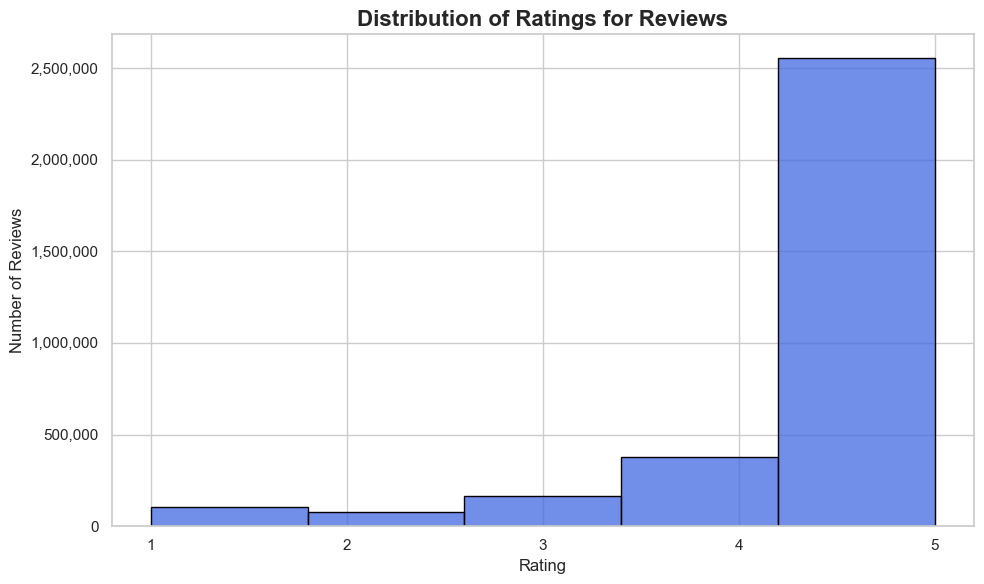

In [16]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load the data
data_file = 'cleaned_metadata.jsonl'
with open(data_file, 'r') as f:
    data = [json.loads(line) for line in f]

# Extract ratings from reviews, ensuring 'reviews' exists
ratings = []
for album in data:
    if 'reviews' in album:  # Check if 'reviews' exists in the album
        for review in album['reviews']:
            ratings.append(review['rating'])

# Set Seaborn style
sns.set(style="whitegrid", palette="muted")

# Create a plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(ratings, bins=5, kde=False, color='royalblue', edgecolor='black')

# Customizing the title and labels
plt.title('Distribution of Ratings for Reviews', fontsize=16, weight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Formatting the y-axis to avoid scientific notation
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax.yaxis.set_major_formatter(formatter)

# Set the ticks on the x-axis for the ratings
plt.xticks([1, 2, 3, 4, 5])

# Show the plot
plt.tight_layout()
plt.show()


### 2. Sentiment Score Distribution

The **Sentiment Score Distribution** visualization provides a detailed view of the sentiment scores across all reviews. Using a histogram with a Kernel Density Estimate (KDE) overlay, it visualizes how sentiment scores (ranging from negative to positive) are distributed. Each bar in the histogram represents the frequency of reviews within a specific sentiment range, while the KDE curve provides a smoothed representation of the overall sentiment distribution. This approach helps in understanding the general sentiment trend, such as whether the majority of reviews lean positive, negative, or neutral.

By analyzing this visualization, it is possible to identify patterns and outliers in the sentiment scores. For example, if there is a high concentration of positive sentiment, it suggests that most reviews are favorable. On the other hand, if the distribution is more balanced or skewed toward negative sentiment, it can indicate areas of dissatisfaction. This visualization is useful for understanding how customers feel about products or services and can be a valuable tool for sentiment analysis in business and marketing strategies.

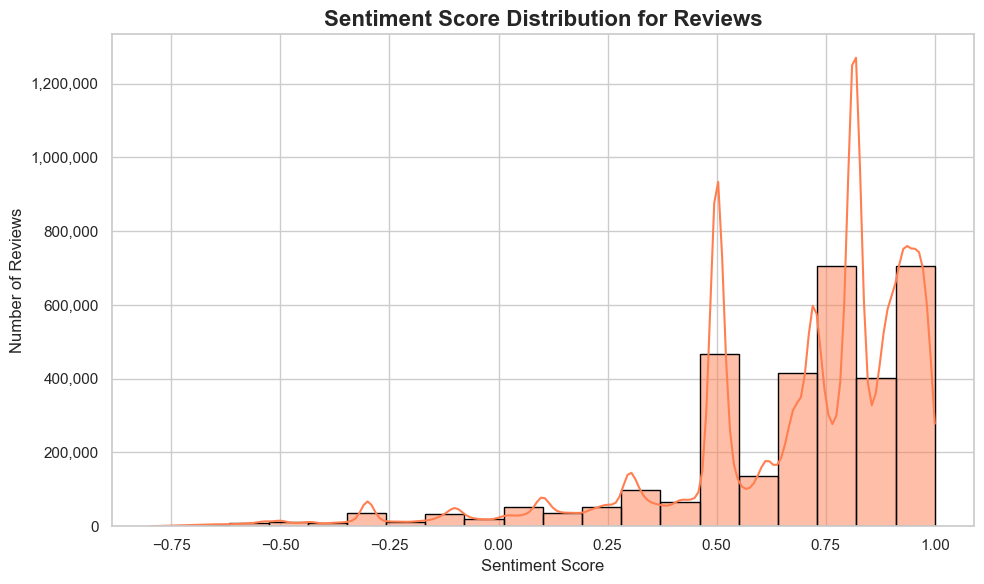

In [17]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load the data
data_file = 'cleaned_metadata.jsonl'
with open(data_file, 'r') as f:
    data = [json.loads(line) for line in f]

# Extract sentiment scores from reviews, ensuring 'reviews' exists
sentiment_scores = []
for album in data:
    if 'reviews' in album:  # Check if 'reviews' exists in the album
        for review in album['reviews']:
            sentiment_scores.append(review['sentiment_score'])

# Set Seaborn style
sns.set(style="whitegrid", palette="muted")

# Create a histogram of sentiment scores
plt.figure(figsize=(10, 6))
ax = sns.histplot(sentiment_scores, kde=True, bins=20, color='coral', edgecolor='black')

# Customizing the title and labels
plt.title('Sentiment Score Distribution for Reviews', fontsize=16, weight='bold')
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Formatting the y-axis to avoid scientific notation
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax.yaxis.set_major_formatter(formatter)

# Show the plot
plt.tight_layout()
plt.show()

### 3. Average Rating vs. Sentiment Score

The **Average Rating vs Average Sentiment Score** visualization employs a hexbin plot to display the relationship between the average product rating and the average sentiment score of customer reviews. This type of plot is particularly useful for identifying patterns and correlations between two continuous variables. In this case, it allows us to observe how sentiment aligns with ratings across multiple products, helping to see if higher ratings correlate with more positive sentiment in reviews. The logarithmic scaling of the color bar indicates the density of reviews in each hexbin, making it easier to spot clusters of high or low ratings and sentiments.

The hexbin plot provides an insightful view of the overall trends in customer feedback. It helps identify areas where products with higher average ratings tend to also have more positive sentiments, or where lower ratings might indicate negative sentiments. The use of logarithmic scaling on the color bar is effective in handling areas with dense data, improving clarity by avoiding visual clutter. This visualization is ideal for exploring customer satisfaction and sentiment on a broader scale, allowing for quick identification of general trends in user opinions.

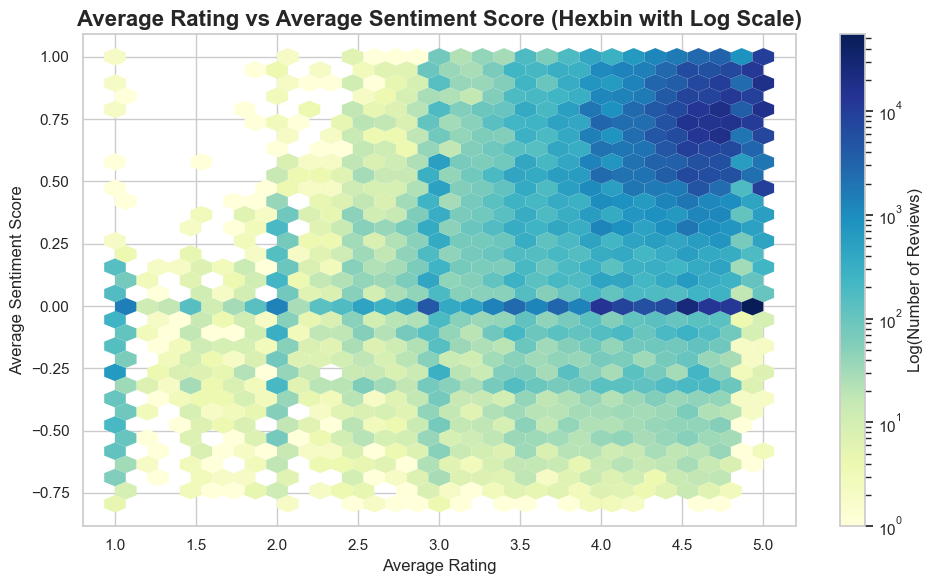

In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Pre-allocate lists for average ratings and average sentiment scores
avg_ratings = []
avg_sentiment_scores = []

# Use list comprehension to extract the data more efficiently
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        # Extract the average rating and average sentiment score for each album
        avg_ratings.append(album['average_rating'])
        avg_sentiment_scores.append(album['average_sentiment_score'])

# Convert to numpy arrays for faster calculations
avg_ratings = np.array(avg_ratings)
avg_sentiment_scores = np.array(avg_sentiment_scores)

# Set Seaborn style for aesthetics
sns.set(style="whitegrid", palette="muted")

# Create hexbin plot with logarithmic scaling of the color bar
plt.figure(figsize=(10, 6))
hb = plt.hexbin(avg_ratings, avg_sentiment_scores, gridsize=30, cmap='YlGnBu', edgecolors='none', bins='log')

# Add a color bar to indicate the number of reviews with log scale
cb = plt.colorbar(hb)
cb.set_label('Log(Number of Reviews)')

# Customizing the title and labels
plt.title('Average Rating vs Average Sentiment Score (Hexbin with Log Scale)', fontsize=16, weight='bold')
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### 4. Sentiment Analysis Breakdown 

The **Sentiment Analysis Breakdown** visualization uses a pie chart to represent the proportion of positive, negative, and neutral reviews in the dataset. By aggregating sentiment data from the reviews, the pie chart allows us to quickly assess the overall sentiment distribution of customer feedback. This breakdown is essential for understanding how customers feel about the products, providing an intuitive way to gauge general satisfaction and dissatisfaction levels. The chart highlights the relative sizes of each sentiment category, making it easy to compare them at a glance.

The use of color-coded segments for positive, negative, and neutral reviews helps differentiate the categories, with a slight "explode" effect applied to the positive segment to draw attention. The clean styling and custom annotations, such as the total number of reviews, add a professional touch, ensuring the chart is both informative and visually appealing. This type of visualization is crucial for stakeholders to assess sentiment trends, guide product improvements, and strategize customer engagement efforts.

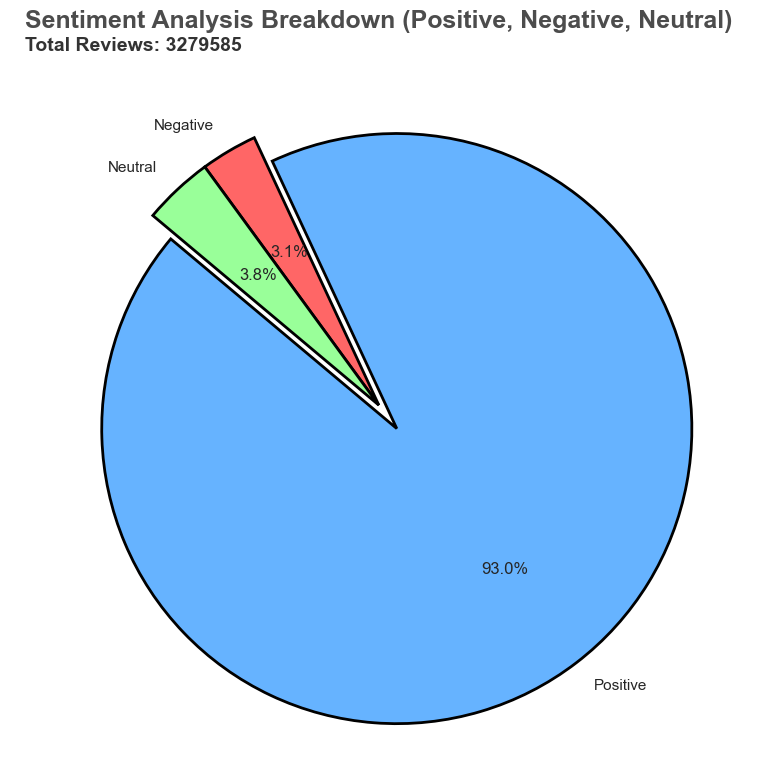

In [19]:
import json
import matplotlib.pyplot as plt

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Initialize counters for sentiment breakdown
positive_count = 0
negative_count = 0
neutral_count = 0

# Iterate over the data and aggregate sentiment counts
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        
        # Check if the keys for sentiment counts exist
        if 'positive_reviews_count' in album and 'negative_reviews_count' in album and 'neutral_reviews_count' in album:
            positive_count += album['positive_reviews_count']
            negative_count += album['negative_reviews_count']
            neutral_count += album['neutral_reviews_count']

# Data for the pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_count, negative_count, neutral_count]
colors = ['#66b3ff', '#ff6666', '#99ff99']  # Colors for the segments
explode = (0.1, 0, 0)  # Explode the first slice (Positive) slightly

# Plot the pie chart with clean styling
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})

# Customizing the title with a stylish font
plt.title('Sentiment Analysis Breakdown (Positive, Negative, Neutral)', fontsize=18, weight='bold', color='#4c4c4c', fontname='Arial')

# Add a more elegant text annotation for emphasis
plt.text(-1.2, 1.2, f"Total Reviews: {sum(sizes)}", fontsize=14, color='#333333', weight='bold', fontname='Arial')

# Show the plot with tight layout
plt.tight_layout()

# Display the plot
plt.show()


### 5. Word Count vs. Sentiment Score

The **Heatmap of Word Count vs. Sentiment Score** visualizes the relationship between the length of reviews (measured in word count) and the sentiment scores assigned to those reviews. The plot uses a **logarithmic color scale** to represent the number of reviews that fall into specific bins of word count and sentiment score, making it easier to identify patterns and trends in the dataset. This type of heatmap is helpful for understanding how the length of a review correlates with sentiment, providing insight into whether longer reviews tend to have more positive or negative sentiment or if shorter reviews have a different sentiment distribution.

The x-axis represents the **word count**, and the y-axis represents the **sentiment score**, ranging from -1 (negative) to +1 (positive). The heatmap is generated by binning the data into **word count** and **sentiment** bins, with colors indicating the frequency of reviews in each combination of word count and sentiment score. The use of a logarithmic scale on the color bar enhances the visibility of areas with higher review densities. This adjustment is particularly important because the distribution of reviews often shows a skew, where more common values (e.g., short reviews with neutral sentiment) dominate the plot. The logarithmic scale helps to compress these frequent areas while emphasizing less common but potentially important combinations of word count and sentiment. This visualization allows for an in-depth understanding of how review length and sentiment are interrelated, guiding businesses or researchers in identifying key patterns in customer feedback.

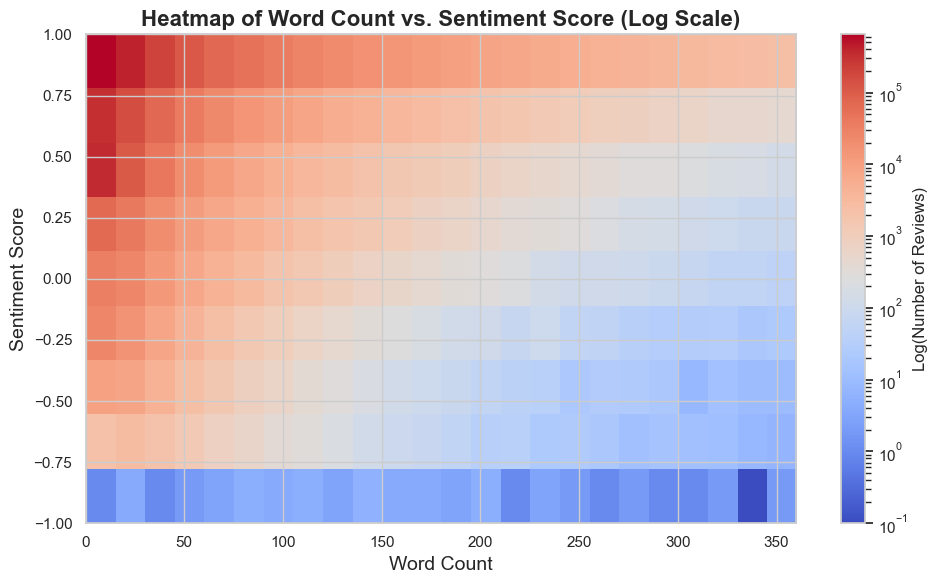

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Lists for word count and sentiment score
word_counts = []
sentiment_scores = []

# Iterate over the data and collect word count and sentiment score
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        for review in album.get('reviews', []):
            word_counts.append(review['word_count'])
            sentiment_scores.append(review['sentiment_score'])

# Convert to NumPy arrays
word_counts = np.array(word_counts)
sentiment_scores = np.array(sentiment_scores)

# Define the range and aggregation bins
max_word_count = int(np.percentile(word_counts, 99))  # Limit to 99th percentile for word counts
min_sentiment, max_sentiment = -1, 1  # Sentiment score range

# Define the bin edges for word count and sentiment
word_bin_edges = np.linspace(0, max_word_count, 25)  # 20 bins for word count
sentiment_bin_edges = np.linspace(min_sentiment, max_sentiment, 10)  # 10 bins for sentiment scores

# Aggregate data by counting the number of reviews in each bin
heatmap, _, _ = np.histogram2d(
    sentiment_scores,
    word_counts,
    bins=[sentiment_bin_edges, word_bin_edges]
)

# Avoid issues with zero by adding a small constant (for log scale)
heatmap = np.where(heatmap == 0, 1e-1, heatmap)

# Plot the heatmap with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.imshow(
    heatmap,
    origin='lower',
    aspect='auto',
    extent=[0, max_word_count, min_sentiment, max_sentiment],
    cmap='coolwarm',
    norm=mcolors.LogNorm(vmin=heatmap.min(), vmax=heatmap.max())  # Logarithmic scale
)

# Add colorbar with log scale
cbar = plt.colorbar()
cbar.set_label('Log(Number of Reviews)', fontsize=12)

# Add title and labels
plt.title('Heatmap of Word Count vs. Sentiment Score (Log Scale)', fontsize=16, weight='bold')
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### 6. Price vs. Average Rating

The **Heatmap of Price vs. Average Rating** visualizes the relationship between product price and average rating using a 2D histogram, where the frequency of products within specific price and rating ranges is displayed with a **logarithmic color scale**. This log scale is particularly useful because the data likely contains many products with positive reviews, leading to a concentration of data points in certain regions of the plot. By applying a logarithmic transformation to the frequency values, we can better represent the entire distribution and under-represent areas with disproportionately high frequencies. This ensures that less common combinations (such as high-priced products with low ratings) are not obscured by the overwhelming number of products in other regions.

The x-axis of the heatmap represents **price ranges**, such as $0-$25, $25-$50, etc., while the y-axis shows the **rating ranges** (e.g., 0-1, 1-2). The colors indicate the frequency of products in each combination of price and rating, with darker shades corresponding to higher frequencies. The logarithmic scaling allows for a more balanced visualization, where both high and low-frequency areas are appropriately represented, making it easier to detect patterns or trends that might otherwise be hidden due to the dominance of more common price and rating combinations. This helps analysts identify correlations between pricing and ratings while ensuring that rare data points are not overlooked.


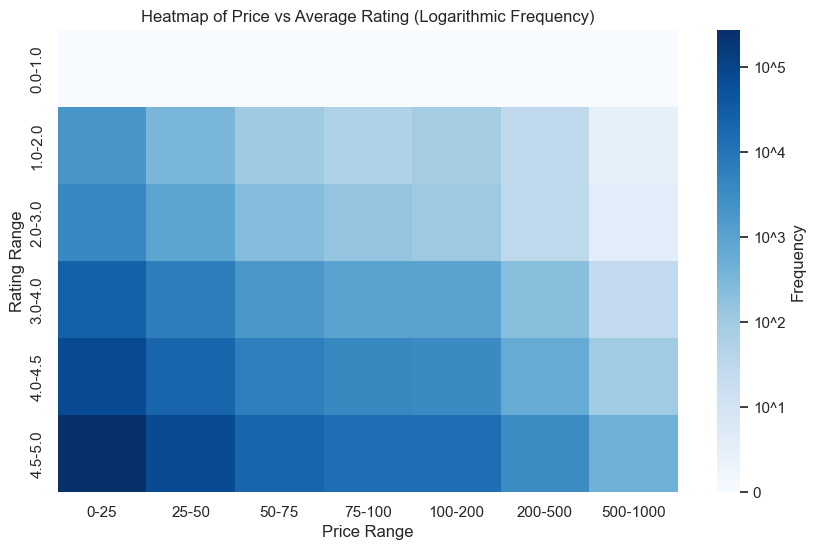

In [21]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Load the data from the JSONL file
data_file = 'cleaned_metadata.jsonl'

# Lists to store product titles, prices, and average ratings
products = []

# Read the data and extract relevant information
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        # Ensure the album has both title, price, and average_rating attributes
        if 'title' in album and 'price' in album and 'average_rating' in album:
            price_str = album['price']
            
            # Handle cases where price is null (None)
            if price_str is None:
                continue  # Skip this entry if the price is null
            
            # If the price is a string, clean it to keep only numeric characters
            if isinstance(price_str, str):
                price = ''.join(filter(str.isdigit, price_str))
                if price:
                    price = float(price)
                else:
                    continue  # Skip invalid prices
            elif isinstance(price_str, (int, float)):
                price = float(price_str)
            
            # Store the valid product, its price, and its average_rating
            products.append({
                'title': album['title'], 
                'price': price, 
                'average_rating': album['average_rating']
            })

# Create a DataFrame from the products list
df = pd.DataFrame(products)

# Convert to numeric, set invalid values to NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with NaN values in 'price' or 'average_rating'
df = df.dropna(subset=['price', 'average_rating'])

# Exclude prices above 1000
df = df[df['price'] <= 1000]

# Define the price and rating bins
price_bins = [0, 25, 50, 75, 100, 200, 500, 1000]
rating_bins = [0, 1, 2, 3, 4, 4.5, 5]

# Create a 2D histogram for the heatmap
heatmap_data, xedges, yedges = np.histogram2d(df['price'], df['average_rating'], bins=[price_bins, rating_bins])

# Take log of the frequency, adding a small constant to handle zero values
log_heatmap_data = np.log10(heatmap_data.T + 1)

# Create the heatmap
plt.figure(figsize=(10, 6))

# Custom formatter for the colorbar to show 10^n
def log_fmt(x, pos):
    return f'10^{int(x)}' if x > 0 else '0'

# Create the heatmap
ax = sns.heatmap(
    log_heatmap_data, 
    xticklabels=[f'{x1}-{x2}' for x1, x2 in zip(xedges[:-1], xedges[1:])], 
    yticklabels=[f'{y1}-{y2}' for y1, y2 in zip(yedges[:-1], yedges[1:])], 
    cmap='Blues', 
    cbar_kws={
        'label': 'Frequency',
        'format': ticker.FuncFormatter(log_fmt)
    }
)

plt.xlabel('Price Range')
plt.ylabel('Rating Range')
plt.title('Heatmap of Price vs Average Rating (Logarithmic Frequency)')
plt.show()

### 7. Average Rating and Sentiment Score Over Time

The **Average Rating and Sentiment Score Over Time** graphs display the temporal trends of customer feedback across albums. The first plot shows how the average ratings evolve over time, while the second plot illustrates changes in the average sentiment scores. Both of these visualizations help in understanding long-term shifts in user satisfaction and sentiment, which can be valuable for businesses and researchers looking to track customer feedback trends over specific periods.

To smooth the trends and reduce noise, a **rolling average** with a window of 6 months is applied to both the rating and sentiment score data. This smoothing technique is essential because it helps highlight the underlying trend without being distracted by seasonal or short-term fluctuations. The rolling average effectively stabilizes the plot, offering clearer insights into long-term shifts rather than reacting to every minor fluctuation in the data. The plots use **line charts** with smoothed data, making it easy to observe the overall trajectory of ratings and sentiment, and the time intervals are presented by **Year-Month** labels. These visualizations serve as a valuable tool for identifying key moments of change, which can be linked to events or product changes.

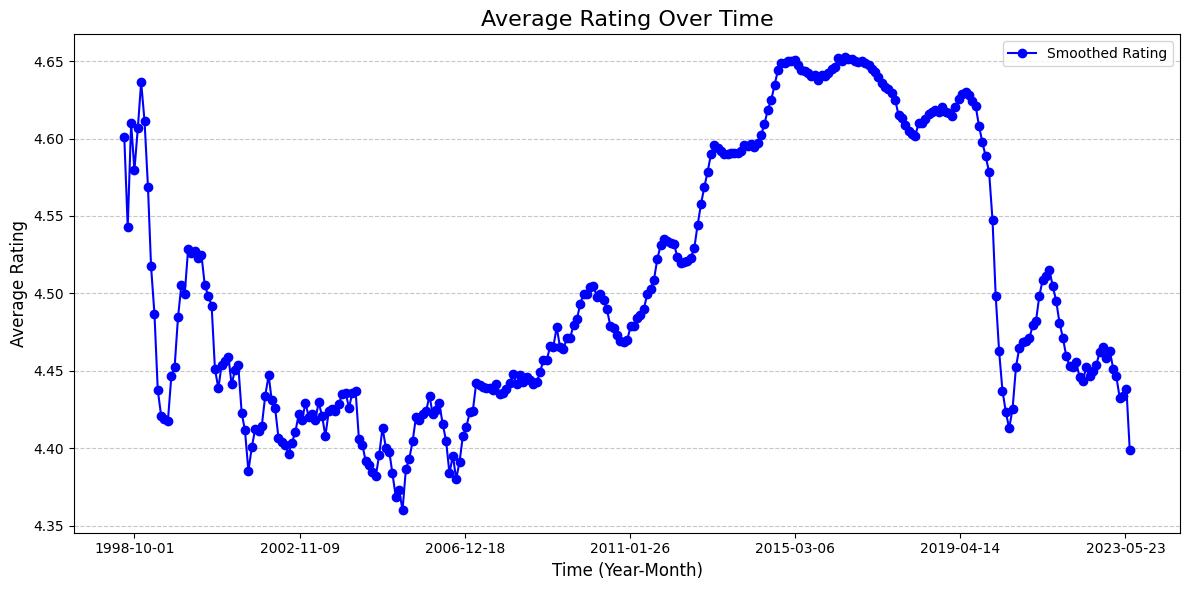

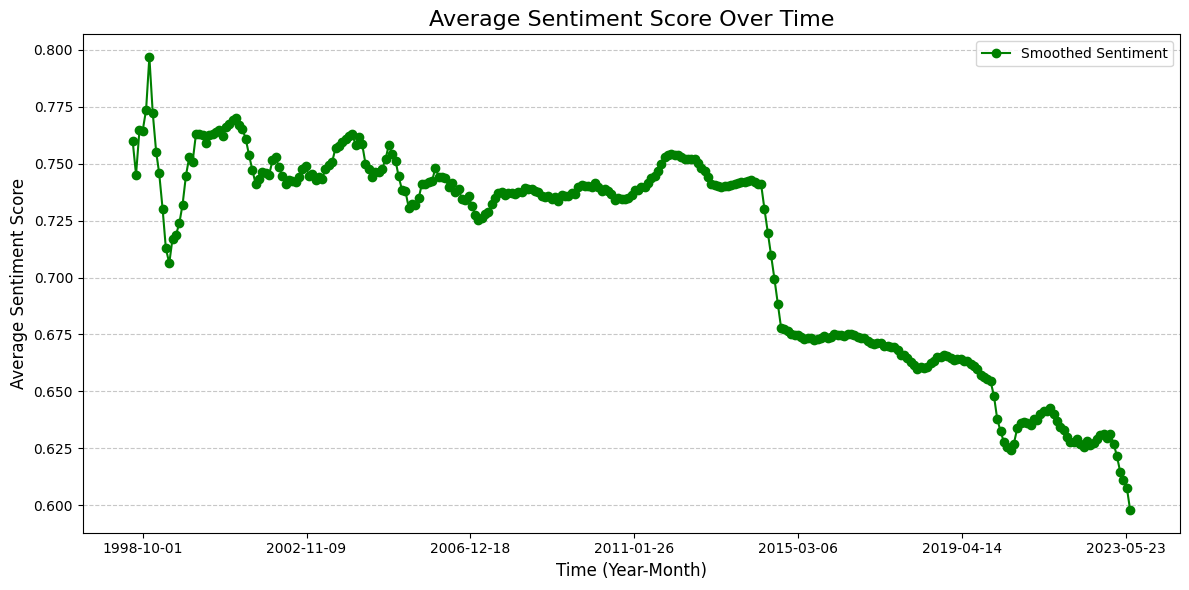

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the JSONL file
data_file = 'cleaned_metadata.jsonl'

# Lists to store reviews with timestamps, ratings, and sentiment scores
review_data = []

# Read the JSONL file
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        if 'reviews' in album:
            for review in album['reviews']:
                if 'timestamp' in review and 'rating' in review and 'sentiment_score' in review:
                    review_data.append({
                        'timestamp': review['timestamp'],
                        'rating': review['rating'],
                        'sentiment_score': review['sentiment_score']
                    })

# Create a DataFrame
df_reviews = pd.DataFrame(review_data)

# Convert 'timestamp' to datetime
df_reviews['timestamp'] = pd.to_datetime(df_reviews['timestamp'])

# Group by year-month and calculate the average rating and sentiment score
df_reviews['year_month'] = df_reviews['timestamp'].dt.to_period('M')
ratings_over_time = df_reviews.groupby('year_month')['rating'].mean().reset_index()
sentiment_over_time = df_reviews.groupby('year_month')['sentiment_score'].mean().reset_index()

# Convert period to datetime for plotting
ratings_over_time['year_month'] = ratings_over_time['year_month'].dt.to_timestamp()
sentiment_over_time['year_month'] = sentiment_over_time['year_month'].dt.to_timestamp()

# Apply a rolling average to smooth the graphs
ratings_over_time['smoothed_rating'] = ratings_over_time['rating'].rolling(window=6, center=True).mean()
sentiment_over_time['smoothed_sentiment'] = sentiment_over_time['sentiment_score'].rolling(window=6, center=True).mean()

# Plot the average rating over time
plt.figure(figsize=(12, 6))
plt.plot(ratings_over_time['year_month'], ratings_over_time['smoothed_rating'], 
         marker='o', color='blue', label='Smoothed Rating')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Show only 10 labels evenly spaced
plt.title('Average Rating Over Time', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the average sentiment score over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_over_time['year_month'], sentiment_over_time['smoothed_sentiment'], 
         marker='o', color='green', label='Smoothed Sentiment')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Show only 10 labels evenly spaced
plt.title('Average Sentiment Score Over Time', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### 8. Word Clouds for Positive and Negative Reviews

The **Word Clouds for Positive and Negative Reviews** visually represent the most frequently used words in customer reviews based on sentiment. These word clouds are a powerful tool for quickly identifying the themes and common expressions found in both positive and negative feedback.

- **Positive Reviews:** The word cloud for positive reviews highlights the words that are most often used in reviews with a sentiment score greater than 0.2. The larger the word appears in the cloud, the more frequently it is mentioned. This allows for a quick visualization of the key aspects that customers appreciate about the albums, such as certain features, qualities, or general terms of satisfaction.

- **Negative Reviews:** Similarly, the word cloud for negative reviews displays the most common words used in reviews with a sentiment score less than -0.2. The larger words in this cloud represent the most frequently mentioned criticisms or issues that customers experienced, allowing for easy identification of pain points or dissatisfaction.

By visualizing these word clouds, businesses or researchers can quickly grasp the key topics and sentiments expressed in customer feedback, offering valuable insights into what aspects of the product are well-received or need improvement.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


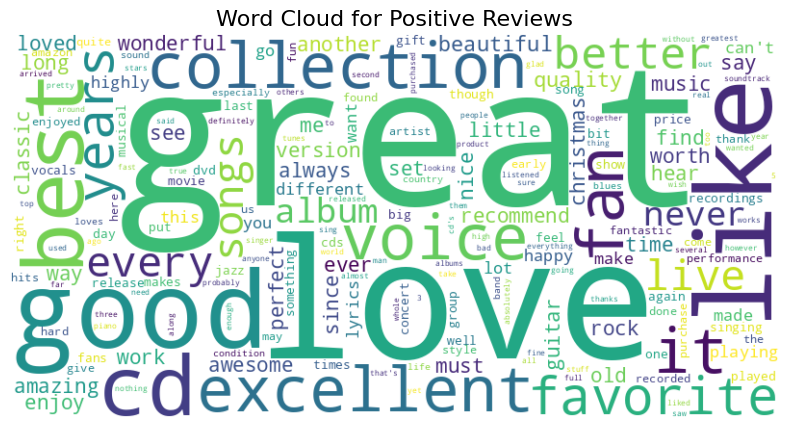

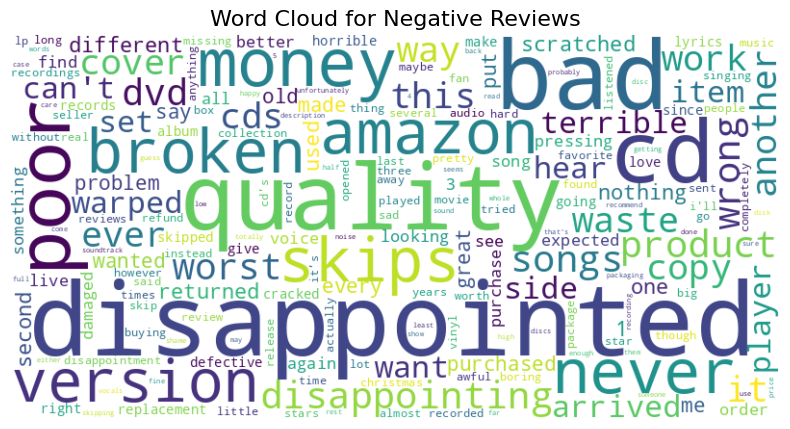

In [7]:
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Ensure you have the necessary NLTK stopwords
nltk.download('stopwords')

# Load data
data_file = 'cleaned_metadata.jsonl'
reviews = []
stop_words = set(stopwords.words('english'))

# Custom stopwords list
custom_stopwords = {
    "album", "music", "cd", "track", "song", "The", "this",
    "that", "it", "is", "was", "and", "in", "on", "for", "with",
    "by", "to", "of", "a", "an", "i", "you", "we", "they", "I",
    "the", "It", "This", "this", "CD", "would", "Would", "one", "songs",
    "-", "it.", "get", "record", "first", "A", "sound", "even",
    "vinyl", "case", "if", "If", "time", "play", "much", "bought",
    "got", "original", "album.", "new", "I'm", "music.", "CD.", "two",
    "buy", "Very", "2", "disc", "still", "thought", "listen", "really",
    "many", "back", "could", "came", "received", "sounds", "know", "it's",
    "tracks", "recording", "heard", "It's", "return", "band", "well", "i've",
    "My", "listening", "ordered", "&", "also", "There", "think", "albums", "i'm", "it."
}

# Combine custom stopwords with NLTK stopwords
stop_words.update(custom_stopwords)

# Extract reviews and sentiment scores
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        for review in album.get("reviews", []):
            reviews.append({
                "text": review["text"],
                "sentiment_score": review["sentiment_score"]
            })

# Separate positive and negative reviews
positive_reviews = [review["text"] for review in reviews if review["sentiment_score"] > 0.2]
negative_reviews = [review["text"] for review in reviews if review["sentiment_score"] < -0.2]

# Preprocess and tokenize text
def preprocess_reviews(reviews, extra_stopwords=None):
    tokens = []
    for review in reviews:
        words = review.lower().split()
        words = [
            word.strip('.,!?;:()[]"') for word in words 
            if word not in stop_words and (extra_stopwords is None or word not in extra_stopwords)
        ]
        tokens.extend(words)
    return tokens

# Remove "like" only from negative reviews
positive_tokens = preprocess_reviews(positive_reviews)
negative_tokens = preprocess_reviews(negative_reviews, extra_stopwords={"like", "good"})

# Generate word frequency counters
positive_word_freq = Counter(positive_tokens)
negative_word_freq = Counter(negative_tokens)

# Generate WordClouds
def create_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Positive Word Cloud
create_wordcloud(positive_word_freq, "Word Cloud for Positive Reviews")

# Negative Word Cloud
create_wordcloud(negative_word_freq, "Word Cloud for Negative Reviews")


## Conclusion
In conclusion, this project demonstrated how the integration of **data wrangling**, **feature engineering**, **exploratory data analysis (EDA)**, and **data visualization** can provide profound insights into **customer sentiment** through the analysis of product reviews. By examining the sentiment scores alongside other key variables, the analysis uncovered significant trends such as the correlation between **product price** and **rating**, the relationship between **review length** and sentiment, and shifts in **customer satisfaction** over time. The use of **word clouds** and **heatmaps** enhanced the understanding of sentiment distribution, revealing both **qualitative** and **quantitative** patterns within the feedback.

Understanding the sentiment expressed in customer reviews enables businesses to identify underlying **emotional drivers** of customer behavior, refine their products, and adjust marketing strategies accordingly. This project highlights the power of **sentiment analysis** in uncovering actionable insights from customer feedback, offering a deeper understanding of consumer attitudes, preferences, and perceptions. By leveraging such insights, businesses can enhance customer satisfaction, improve their offerings, and drive **long-term success** in a competitive marketplace.